In [2]:
!pip install torch torchvision matplotlib

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


 ### 加載和預處理圖片

In [4]:
import os
import torch
from torchvision import transforms
from PIL import Image

# 定義圖片目錄和變換
image_dir = '/content/drive/MyDrive/Colab Notebooks/image'  # 圖片資料夾路徑
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor()
])

# 加載圖片
images = []
for file_name in os.listdir(image_dir):
    if file_name.endswith('img_.png'):
        image_path = os.path.join(image_dir, file_name)
        image = Image.open(image_path).convert('RGB')
        image = transform(image)
        images.append(image)

# 創建數據集和數據加載器
dataset = torch.utils.data.TensorDataset(torch.stack(images))
dataloader = torch.utils.data.DataLoader(dataset, batch_size=4, shuffle=True)

### 定義和訓練DIP模型 (練習)

In [5]:
import torch.nn as nn
import torch.optim as optim

class DIP(nn.Module):
    def __init__(self):
        super(DIP, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 3, kernel_size=3, padding=1)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = self.conv3(x)
        return x

# DIP模型訓練
dip_model = DIP().cuda()
optimizer = optim.Adam(dip_model.parameters(), lr=0.01)
criterion = nn.MSELoss()

def train_dip(model, target_image, num_epochs=1000):
    model.train()
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        output = model(target_image)
        loss = criterion(output, target_image)
        loss.backward()
        optimizer.step()
        if (epoch + 1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
    return model

# 加載一張目標圖片進行DIP訓練
target_image = images[0].unsqueeze(0).cuda()
trained_dip_model = train_dip(dip_model, target_image)


Epoch [100/1000], Loss: 0.0026
Epoch [200/1000], Loss: 0.0021
Epoch [300/1000], Loss: 0.0016
Epoch [400/1000], Loss: 0.0014
Epoch [500/1000], Loss: 0.0012
Epoch [600/1000], Loss: 0.0011
Epoch [700/1000], Loss: 0.0010
Epoch [800/1000], Loss: 0.0009
Epoch [900/1000], Loss: 0.0008
Epoch [1000/1000], Loss: 0.0008


### 使用DIP模型初始化DDPM

In [6]:
class SimpleDDPM(nn.Module):
    def __init__(self, image_size, in_channels, out_channels, hidden_dim):
        super(SimpleDDPM, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, hidden_dim, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(hidden_dim, hidden_dim, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(hidden_dim, out_channels, kernel_size=3, padding=1)

    def forward(self, x, t):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = self.conv3(x)
        return x

# 初始化DDPM模型
ddpm_model = SimpleDDPM(image_size=64, in_channels=3, out_channels=3, hidden_dim=64).cuda()

# 使用DIP模型輸出初始化DDPM
with torch.no_grad():
    init_image = trained_dip_model(target_image).detach()

# 訓練數據的初始化變為DIP模型的輸出
dataset = torch.utils.data.TensorDataset(init_image.repeat(len(images), 1, 1, 1))
dataloader = torch.utils.data.DataLoader(dataset, batch_size=4, shuffle=True)


### 訓練DDPM模型

In [7]:
from tqdm import tqdm

optimizer = optim.Adam(ddpm_model.parameters(), lr=0.001)
num_epochs = 500  # 增加訓練次數

def diffusion_loss(model, x, t):
    noise = torch.randn_like(x)
    x_noisy = x + noise * t.unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)
    predicted_noise = model(x_noisy, t)
    return nn.MSELoss()(predicted_noise, noise)

for epoch in range(num_epochs):
    ddpm_model.train()
    total_loss = 0
    for x in tqdm(dataloader):
        x = x[0].cuda()
        t = torch.rand(x.size(0)).cuda()
        loss = diffusion_loss(ddpm_model, x, t)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(dataloader)}')


100%|██████████| 223/223 [00:00<00:00, 368.68it/s]


Epoch 1/500, Loss: 0.227609123333019


100%|██████████| 223/223 [00:00<00:00, 472.36it/s]


Epoch 2/500, Loss: 0.09459355341546204


100%|██████████| 223/223 [00:00<00:00, 469.41it/s]


Epoch 3/500, Loss: 0.07410001910120383


100%|██████████| 223/223 [00:00<00:00, 472.46it/s]


Epoch 4/500, Loss: 0.06957609672516986


100%|██████████| 223/223 [00:00<00:00, 458.40it/s]


Epoch 5/500, Loss: 0.07228917334512745


100%|██████████| 223/223 [00:00<00:00, 463.25it/s]


Epoch 6/500, Loss: 0.06633963581224728


100%|██████████| 223/223 [00:00<00:00, 460.49it/s]


Epoch 7/500, Loss: 0.05495811781674757


100%|██████████| 223/223 [00:00<00:00, 357.50it/s]


Epoch 8/500, Loss: 0.05483772463662207


100%|██████████| 223/223 [00:00<00:00, 372.68it/s]


Epoch 9/500, Loss: 0.06259210071956631


100%|██████████| 223/223 [00:00<00:00, 459.77it/s]


Epoch 10/500, Loss: 0.05258408738425494


100%|██████████| 223/223 [00:00<00:00, 463.74it/s]


Epoch 11/500, Loss: 0.05777196203579817


100%|██████████| 223/223 [00:00<00:00, 464.28it/s]


Epoch 12/500, Loss: 0.05247536465325163


100%|██████████| 223/223 [00:00<00:00, 462.70it/s]


Epoch 13/500, Loss: 0.049616646898634764


100%|██████████| 223/223 [00:00<00:00, 301.72it/s]


Epoch 14/500, Loss: 0.05060170585030665


100%|██████████| 223/223 [00:00<00:00, 255.17it/s]


Epoch 15/500, Loss: 0.04474014513227972


100%|██████████| 223/223 [00:01<00:00, 154.67it/s]


Epoch 16/500, Loss: 0.04903026749567868


100%|██████████| 223/223 [00:01<00:00, 155.19it/s]


Epoch 17/500, Loss: 0.0565856471908333


100%|██████████| 223/223 [00:00<00:00, 371.07it/s]


Epoch 18/500, Loss: 0.04457538426256501


100%|██████████| 223/223 [00:00<00:00, 364.15it/s]


Epoch 19/500, Loss: 0.052174448708047244


100%|██████████| 223/223 [00:00<00:00, 377.56it/s]


Epoch 20/500, Loss: 0.04564637448555151


100%|██████████| 223/223 [00:00<00:00, 422.16it/s]


Epoch 21/500, Loss: 0.051255321656374656


100%|██████████| 223/223 [00:00<00:00, 475.42it/s]


Epoch 22/500, Loss: 0.04974379584260051


100%|██████████| 223/223 [00:00<00:00, 474.04it/s]


Epoch 23/500, Loss: 0.0461853396715471


100%|██████████| 223/223 [00:00<00:00, 468.74it/s]


Epoch 24/500, Loss: 0.05084716590463848


100%|██████████| 223/223 [00:00<00:00, 469.42it/s]


Epoch 25/500, Loss: 0.044690090611643855


100%|██████████| 223/223 [00:00<00:00, 467.63it/s]


Epoch 26/500, Loss: 0.04733410080886475


100%|██████████| 223/223 [00:00<00:00, 466.23it/s]


Epoch 27/500, Loss: 0.04904426595054132


100%|██████████| 223/223 [00:00<00:00, 461.95it/s]


Epoch 28/500, Loss: 0.04031452357835834


100%|██████████| 223/223 [00:00<00:00, 460.93it/s]


Epoch 29/500, Loss: 0.04801233682464057


100%|██████████| 223/223 [00:00<00:00, 469.89it/s]


Epoch 30/500, Loss: 0.05193212417877308


100%|██████████| 223/223 [00:00<00:00, 475.36it/s]


Epoch 31/500, Loss: 0.04457045266312869


100%|██████████| 223/223 [00:00<00:00, 468.34it/s]


Epoch 32/500, Loss: 0.053437895287713665


100%|██████████| 223/223 [00:00<00:00, 466.83it/s]


Epoch 33/500, Loss: 0.04116940291205864


100%|██████████| 223/223 [00:00<00:00, 466.10it/s]


Epoch 34/500, Loss: 0.04474043011698755


100%|██████████| 223/223 [00:00<00:00, 465.96it/s]


Epoch 35/500, Loss: 0.04352153717402386


100%|██████████| 223/223 [00:00<00:00, 472.22it/s]


Epoch 36/500, Loss: 0.04520255610380205


100%|██████████| 223/223 [00:00<00:00, 468.84it/s]


Epoch 37/500, Loss: 0.038700877358894714


100%|██████████| 223/223 [00:00<00:00, 466.41it/s]


Epoch 38/500, Loss: 0.04086128010042847


100%|██████████| 223/223 [00:00<00:00, 472.78it/s]


Epoch 39/500, Loss: 0.046148323249322415


100%|██████████| 223/223 [00:00<00:00, 471.10it/s]


Epoch 40/500, Loss: 0.046835531643487416


100%|██████████| 223/223 [00:00<00:00, 467.68it/s]


Epoch 41/500, Loss: 0.044239655989034295


100%|██████████| 223/223 [00:00<00:00, 405.86it/s]


Epoch 42/500, Loss: 0.03843298692239507


100%|██████████| 223/223 [00:00<00:00, 432.64it/s]


Epoch 43/500, Loss: 0.04460788653503619


100%|██████████| 223/223 [00:00<00:00, 417.44it/s]


Epoch 44/500, Loss: 0.04165413679195894


100%|██████████| 223/223 [00:00<00:00, 435.49it/s]


Epoch 45/500, Loss: 0.04014278983388246


100%|██████████| 223/223 [00:00<00:00, 429.93it/s]


Epoch 46/500, Loss: 0.04627731995398154


100%|██████████| 223/223 [00:00<00:00, 376.45it/s]


Epoch 47/500, Loss: 0.03997595412781955


100%|██████████| 223/223 [00:00<00:00, 391.05it/s]


Epoch 48/500, Loss: 0.03510482870710538


100%|██████████| 223/223 [00:00<00:00, 398.77it/s]


Epoch 49/500, Loss: 0.04578874266034017


100%|██████████| 223/223 [00:00<00:00, 463.25it/s]


Epoch 50/500, Loss: 0.04436957026777513


100%|██████████| 223/223 [00:00<00:00, 459.89it/s]


Epoch 51/500, Loss: 0.041845359083582466


100%|██████████| 223/223 [00:00<00:00, 475.37it/s]


Epoch 52/500, Loss: 0.0371173198163643


100%|██████████| 223/223 [00:00<00:00, 471.87it/s]


Epoch 53/500, Loss: 0.039551303692730015


100%|██████████| 223/223 [00:00<00:00, 478.35it/s]


Epoch 54/500, Loss: 0.04357983204515258


100%|██████████| 223/223 [00:00<00:00, 467.70it/s]


Epoch 55/500, Loss: 0.04581655988745358


100%|██████████| 223/223 [00:00<00:00, 469.91it/s]


Epoch 56/500, Loss: 0.04466599045580278


100%|██████████| 223/223 [00:00<00:00, 463.52it/s]


Epoch 57/500, Loss: 0.03632945364399608


100%|██████████| 223/223 [00:00<00:00, 474.48it/s]


Epoch 58/500, Loss: 0.040049744703109486


100%|██████████| 223/223 [00:00<00:00, 460.13it/s]


Epoch 59/500, Loss: 0.03670111397957855


100%|██████████| 223/223 [00:00<00:00, 454.70it/s]


Epoch 60/500, Loss: 0.0398203101877808


100%|██████████| 223/223 [00:00<00:00, 461.02it/s]


Epoch 61/500, Loss: 0.04602405791392241


100%|██████████| 223/223 [00:00<00:00, 467.91it/s]


Epoch 62/500, Loss: 0.042267508011294586


100%|██████████| 223/223 [00:00<00:00, 441.67it/s]


Epoch 63/500, Loss: 0.050140116940097956


100%|██████████| 223/223 [00:00<00:00, 469.95it/s]


Epoch 64/500, Loss: 0.040287237255228474


100%|██████████| 223/223 [00:00<00:00, 461.16it/s]


Epoch 65/500, Loss: 0.04032259943139126


100%|██████████| 223/223 [00:00<00:00, 462.45it/s]


Epoch 66/500, Loss: 0.04165685405712491


100%|██████████| 223/223 [00:00<00:00, 463.87it/s]


Epoch 67/500, Loss: 0.04287309407553063


100%|██████████| 223/223 [00:00<00:00, 471.68it/s]


Epoch 68/500, Loss: 0.03768993390415014


100%|██████████| 223/223 [00:00<00:00, 470.34it/s]


Epoch 69/500, Loss: 0.03545176168494428


100%|██████████| 223/223 [00:00<00:00, 420.15it/s]


Epoch 70/500, Loss: 0.048350374928504365


100%|██████████| 223/223 [00:00<00:00, 412.62it/s]


Epoch 71/500, Loss: 0.03800725118328103


100%|██████████| 223/223 [00:00<00:00, 408.66it/s]


Epoch 72/500, Loss: 0.03703107253017714


100%|██████████| 223/223 [00:00<00:00, 424.26it/s]


Epoch 73/500, Loss: 0.04668919862385822


100%|██████████| 223/223 [00:00<00:00, 421.55it/s]


Epoch 74/500, Loss: 0.04416848674850881


100%|██████████| 223/223 [00:00<00:00, 392.21it/s]


Epoch 75/500, Loss: 0.039450508371129164


100%|██████████| 223/223 [00:00<00:00, 395.13it/s]


Epoch 76/500, Loss: 0.0414312712330321


100%|██████████| 223/223 [00:00<00:00, 458.93it/s]


Epoch 77/500, Loss: 0.03425142223291066


100%|██████████| 223/223 [00:00<00:00, 466.34it/s]


Epoch 78/500, Loss: 0.05070284552738538


100%|██████████| 223/223 [00:00<00:00, 457.20it/s]


Epoch 79/500, Loss: 0.0376065513411445


100%|██████████| 223/223 [00:00<00:00, 470.61it/s]


Epoch 80/500, Loss: 0.03566232765502726


100%|██████████| 223/223 [00:00<00:00, 463.93it/s]


Epoch 81/500, Loss: 0.044573658709769294


100%|██████████| 223/223 [00:00<00:00, 472.87it/s]


Epoch 82/500, Loss: 0.04114593108573035


100%|██████████| 223/223 [00:00<00:00, 461.22it/s]


Epoch 83/500, Loss: 0.04127900902131748


100%|██████████| 223/223 [00:00<00:00, 469.61it/s]


Epoch 84/500, Loss: 0.03795708526310097


100%|██████████| 223/223 [00:00<00:00, 458.13it/s]


Epoch 85/500, Loss: 0.040970618022196495


100%|██████████| 223/223 [00:00<00:00, 466.94it/s]


Epoch 86/500, Loss: 0.03634704939286003


100%|██████████| 223/223 [00:00<00:00, 460.93it/s]


Epoch 87/500, Loss: 0.036125322185757446


100%|██████████| 223/223 [00:00<00:00, 468.23it/s]


Epoch 88/500, Loss: 0.036117363169856136


100%|██████████| 223/223 [00:00<00:00, 461.94it/s]


Epoch 89/500, Loss: 0.044989964386005575


100%|██████████| 223/223 [00:00<00:00, 461.20it/s]


Epoch 90/500, Loss: 0.0423031480974547


100%|██████████| 223/223 [00:00<00:00, 454.90it/s]


Epoch 91/500, Loss: 0.04719030446134875


100%|██████████| 223/223 [00:00<00:00, 454.94it/s]


Epoch 92/500, Loss: 0.04362097227185831


100%|██████████| 223/223 [00:00<00:00, 459.69it/s]


Epoch 93/500, Loss: 0.03561641547344458


100%|██████████| 223/223 [00:00<00:00, 455.80it/s]


Epoch 94/500, Loss: 0.04139411197181774


100%|██████████| 223/223 [00:00<00:00, 460.56it/s]


Epoch 95/500, Loss: 0.03636514335336172


100%|██████████| 223/223 [00:00<00:00, 454.69it/s]


Epoch 96/500, Loss: 0.04224554337394077


100%|██████████| 223/223 [00:00<00:00, 398.18it/s]


Epoch 97/500, Loss: 0.04204807794682114


100%|██████████| 223/223 [00:00<00:00, 397.55it/s]


Epoch 98/500, Loss: 0.03972281611653989


100%|██████████| 223/223 [00:00<00:00, 247.11it/s]


Epoch 99/500, Loss: 0.04055031272895935


100%|██████████| 223/223 [00:00<00:00, 232.65it/s]


Epoch 100/500, Loss: 0.033761344081617795


100%|██████████| 223/223 [00:00<00:00, 371.72it/s]


Epoch 101/500, Loss: 0.039585654753272845


100%|██████████| 223/223 [00:00<00:00, 411.89it/s]


Epoch 102/500, Loss: 0.042308362434730934


100%|██████████| 223/223 [00:00<00:00, 473.36it/s]


Epoch 103/500, Loss: 0.03936655299044778


100%|██████████| 223/223 [00:00<00:00, 460.51it/s]


Epoch 104/500, Loss: 0.04144041621932267


100%|██████████| 223/223 [00:00<00:00, 467.42it/s]


Epoch 105/500, Loss: 0.03426522088775854


100%|██████████| 223/223 [00:00<00:00, 458.17it/s]


Epoch 106/500, Loss: 0.036115122324214925


100%|██████████| 223/223 [00:00<00:00, 466.70it/s]


Epoch 107/500, Loss: 0.038054212226194116


100%|██████████| 223/223 [00:00<00:00, 447.34it/s]


Epoch 108/500, Loss: 0.05101849746811016


100%|██████████| 223/223 [00:00<00:00, 463.32it/s]


Epoch 109/500, Loss: 0.030479819718497753


100%|██████████| 223/223 [00:00<00:00, 459.50it/s]


Epoch 110/500, Loss: 0.04137521035000348


100%|██████████| 223/223 [00:00<00:00, 459.47it/s]


Epoch 111/500, Loss: 0.035397306878136414


100%|██████████| 223/223 [00:00<00:00, 460.03it/s]


Epoch 112/500, Loss: 0.040654180070276755


100%|██████████| 223/223 [00:00<00:00, 455.70it/s]


Epoch 113/500, Loss: 0.03815785566587085


100%|██████████| 223/223 [00:00<00:00, 454.34it/s]


Epoch 114/500, Loss: 0.03533752046675826


100%|██████████| 223/223 [00:00<00:00, 458.25it/s]


Epoch 115/500, Loss: 0.033075885755331526


100%|██████████| 223/223 [00:00<00:00, 465.13it/s]


Epoch 116/500, Loss: 0.04357289776807409


100%|██████████| 223/223 [00:00<00:00, 450.42it/s]


Epoch 117/500, Loss: 0.03889233852014146


100%|██████████| 223/223 [00:00<00:00, 455.52it/s]


Epoch 118/500, Loss: 0.03694640597821351


100%|██████████| 223/223 [00:00<00:00, 459.46it/s]


Epoch 119/500, Loss: 0.0382701535980664


100%|██████████| 223/223 [00:00<00:00, 459.66it/s]


Epoch 120/500, Loss: 0.03251672268849317


100%|██████████| 223/223 [00:00<00:00, 447.37it/s]


Epoch 121/500, Loss: 0.042677346391461354


100%|██████████| 223/223 [00:00<00:00, 429.15it/s]


Epoch 122/500, Loss: 0.034507086199829395


100%|██████████| 223/223 [00:00<00:00, 399.11it/s]


Epoch 123/500, Loss: 0.037311610310534725


100%|██████████| 223/223 [00:00<00:00, 406.00it/s]


Epoch 124/500, Loss: 0.034056967207869604


100%|██████████| 223/223 [00:00<00:00, 398.54it/s]


Epoch 125/500, Loss: 0.04522214698784822


100%|██████████| 223/223 [00:00<00:00, 394.09it/s]


Epoch 126/500, Loss: 0.03922687252908277


100%|██████████| 223/223 [00:00<00:00, 393.96it/s]


Epoch 127/500, Loss: 0.03534173924943658


100%|██████████| 223/223 [00:00<00:00, 377.13it/s]


Epoch 128/500, Loss: 0.032666388990967264


100%|██████████| 223/223 [00:00<00:00, 434.35it/s]


Epoch 129/500, Loss: 0.03557705480789122


100%|██████████| 223/223 [00:00<00:00, 449.79it/s]


Epoch 130/500, Loss: 0.038229656911083404


100%|██████████| 223/223 [00:00<00:00, 460.50it/s]


Epoch 131/500, Loss: 0.04096916422348119


100%|██████████| 223/223 [00:00<00:00, 459.84it/s]


Epoch 132/500, Loss: 0.03561495473783781


100%|██████████| 223/223 [00:00<00:00, 454.09it/s]


Epoch 133/500, Loss: 0.036969979548400825


100%|██████████| 223/223 [00:00<00:00, 440.25it/s]


Epoch 134/500, Loss: 0.04625842853912858


100%|██████████| 223/223 [00:00<00:00, 455.56it/s]


Epoch 135/500, Loss: 0.03620663378805323


100%|██████████| 223/223 [00:00<00:00, 447.35it/s]


Epoch 136/500, Loss: 0.035876650835132654


100%|██████████| 223/223 [00:00<00:00, 459.30it/s]


Epoch 137/500, Loss: 0.04909374954120461


100%|██████████| 223/223 [00:00<00:00, 452.41it/s]


Epoch 138/500, Loss: 0.04193119302959988


100%|██████████| 223/223 [00:00<00:00, 456.86it/s]


Epoch 139/500, Loss: 0.03665849862979399


100%|██████████| 223/223 [00:00<00:00, 447.85it/s]


Epoch 140/500, Loss: 0.03455702023321738


100%|██████████| 223/223 [00:00<00:00, 458.87it/s]


Epoch 141/500, Loss: 0.03365427475305684


100%|██████████| 223/223 [00:00<00:00, 456.70it/s]


Epoch 142/500, Loss: 0.03620678483771636


100%|██████████| 223/223 [00:00<00:00, 457.62it/s]


Epoch 143/500, Loss: 0.03731225235512973


100%|██████████| 223/223 [00:00<00:00, 454.92it/s]


Epoch 144/500, Loss: 0.04502072923653863


100%|██████████| 223/223 [00:00<00:00, 448.62it/s]


Epoch 145/500, Loss: 0.04504146458656264


100%|██████████| 223/223 [00:00<00:00, 452.69it/s]


Epoch 146/500, Loss: 0.03685227036476135


100%|██████████| 223/223 [00:00<00:00, 453.51it/s]


Epoch 147/500, Loss: 0.03985653181597924


100%|██████████| 223/223 [00:00<00:00, 454.45it/s]


Epoch 148/500, Loss: 0.04157867574137155


100%|██████████| 223/223 [00:00<00:00, 396.40it/s]


Epoch 149/500, Loss: 0.035612757488951555


100%|██████████| 223/223 [00:00<00:00, 416.68it/s]


Epoch 150/500, Loss: 0.03741006483010647


100%|██████████| 223/223 [00:00<00:00, 388.67it/s]


Epoch 151/500, Loss: 0.037160644090563195


100%|██████████| 223/223 [00:00<00:00, 419.67it/s]


Epoch 152/500, Loss: 0.034940080834143364


100%|██████████| 223/223 [00:00<00:00, 415.01it/s]


Epoch 153/500, Loss: 0.03316664958848814


100%|██████████| 223/223 [00:00<00:00, 380.97it/s]


Epoch 154/500, Loss: 0.04507398229476582


100%|██████████| 223/223 [00:00<00:00, 389.92it/s]


Epoch 155/500, Loss: 0.03415578235391811


100%|██████████| 223/223 [00:00<00:00, 451.27it/s]


Epoch 156/500, Loss: 0.042749893304478426


100%|██████████| 223/223 [00:00<00:00, 454.02it/s]


Epoch 157/500, Loss: 0.03535269547019972


100%|██████████| 223/223 [00:00<00:00, 456.05it/s]


Epoch 158/500, Loss: 0.0410803163783299


100%|██████████| 223/223 [00:00<00:00, 462.57it/s]


Epoch 159/500, Loss: 0.03465033131296592


100%|██████████| 223/223 [00:00<00:00, 460.65it/s]


Epoch 160/500, Loss: 0.038737712891546865


100%|██████████| 223/223 [00:00<00:00, 460.61it/s]


Epoch 161/500, Loss: 0.03375520465285789


100%|██████████| 223/223 [00:00<00:00, 455.11it/s]


Epoch 162/500, Loss: 0.03376290083532911


100%|██████████| 223/223 [00:00<00:00, 451.67it/s]


Epoch 163/500, Loss: 0.03376547890326902


100%|██████████| 223/223 [00:00<00:00, 453.40it/s]


Epoch 164/500, Loss: 0.03705124903654036


100%|██████████| 223/223 [00:00<00:00, 454.34it/s]


Epoch 165/500, Loss: 0.03841277335106391


100%|██████████| 223/223 [00:00<00:00, 456.27it/s]


Epoch 166/500, Loss: 0.03632508551559908


100%|██████████| 223/223 [00:00<00:00, 449.87it/s]


Epoch 167/500, Loss: 0.04036626999888719


100%|██████████| 223/223 [00:00<00:00, 458.45it/s]


Epoch 168/500, Loss: 0.030093035781797808


100%|██████████| 223/223 [00:00<00:00, 447.37it/s]


Epoch 169/500, Loss: 0.0430186556760773


100%|██████████| 223/223 [00:00<00:00, 448.31it/s]


Epoch 170/500, Loss: 0.033603328727018676


100%|██████████| 223/223 [00:00<00:00, 452.28it/s]


Epoch 171/500, Loss: 0.039187558780470234


100%|██████████| 223/223 [00:00<00:00, 455.54it/s]


Epoch 172/500, Loss: 0.03323284847319393


100%|██████████| 223/223 [00:00<00:00, 447.96it/s]


Epoch 173/500, Loss: 0.03791690766477264


100%|██████████| 223/223 [00:00<00:00, 454.47it/s]


Epoch 174/500, Loss: 0.03436748919833134


100%|██████████| 223/223 [00:00<00:00, 432.70it/s]


Epoch 175/500, Loss: 0.0298490196742084


100%|██████████| 223/223 [00:00<00:00, 393.53it/s]


Epoch 176/500, Loss: 0.03718769237098405


100%|██████████| 223/223 [00:00<00:00, 411.53it/s]


Epoch 177/500, Loss: 0.03388403497653023


100%|██████████| 223/223 [00:00<00:00, 407.12it/s]


Epoch 178/500, Loss: 0.036455403967455634


100%|██████████| 223/223 [00:00<00:00, 407.30it/s]


Epoch 179/500, Loss: 0.03567974453148821


100%|██████████| 223/223 [00:00<00:00, 379.89it/s]


Epoch 180/500, Loss: 0.03826679071336316


100%|██████████| 223/223 [00:00<00:00, 384.61it/s]


Epoch 181/500, Loss: 0.03520132269660187


100%|██████████| 223/223 [00:00<00:00, 393.88it/s]


Epoch 182/500, Loss: 0.038689835356222675


100%|██████████| 223/223 [00:00<00:00, 457.78it/s]


Epoch 183/500, Loss: 0.03844907583309663


100%|██████████| 223/223 [00:00<00:00, 448.08it/s]


Epoch 184/500, Loss: 0.030810530869615986


100%|██████████| 223/223 [00:00<00:00, 458.44it/s]


Epoch 185/500, Loss: 0.037969985266838376


100%|██████████| 223/223 [00:00<00:00, 452.63it/s]


Epoch 186/500, Loss: 0.040614299058513256


100%|██████████| 223/223 [00:00<00:00, 451.18it/s]


Epoch 187/500, Loss: 0.032364557735254415


100%|██████████| 223/223 [00:00<00:00, 452.33it/s]


Epoch 188/500, Loss: 0.03343081686461988


100%|██████████| 223/223 [00:00<00:00, 451.32it/s]


Epoch 189/500, Loss: 0.04214641673181356


100%|██████████| 223/223 [00:00<00:00, 440.71it/s]


Epoch 190/500, Loss: 0.03254701921323757


100%|██████████| 223/223 [00:00<00:00, 454.64it/s]


Epoch 191/500, Loss: 0.035259585902763055


100%|██████████| 223/223 [00:00<00:00, 451.99it/s]


Epoch 192/500, Loss: 0.0327081525021738


100%|██████████| 223/223 [00:00<00:00, 461.19it/s]


Epoch 193/500, Loss: 0.03604889901630547


100%|██████████| 223/223 [00:00<00:00, 446.65it/s]


Epoch 194/500, Loss: 0.0334223649744362


100%|██████████| 223/223 [00:00<00:00, 459.55it/s]


Epoch 195/500, Loss: 0.03873214461410527


100%|██████████| 223/223 [00:00<00:00, 455.74it/s]


Epoch 196/500, Loss: 0.036769682157266836


100%|██████████| 223/223 [00:00<00:00, 458.79it/s]


Epoch 197/500, Loss: 0.04105163463746352


100%|██████████| 223/223 [00:00<00:00, 449.95it/s]


Epoch 198/500, Loss: 0.035233954569082626


100%|██████████| 223/223 [00:00<00:00, 450.17it/s]


Epoch 199/500, Loss: 0.032051238594702006


100%|██████████| 223/223 [00:00<00:00, 453.78it/s]


Epoch 200/500, Loss: 0.0398255196053351


100%|██████████| 223/223 [00:00<00:00, 455.09it/s]


Epoch 201/500, Loss: 0.030407813536379103


100%|██████████| 223/223 [00:00<00:00, 425.53it/s]


Epoch 202/500, Loss: 0.031932798310312455


100%|██████████| 223/223 [00:00<00:00, 402.22it/s]


Epoch 203/500, Loss: 0.035036710813441084


100%|██████████| 223/223 [00:00<00:00, 394.08it/s]


Epoch 204/500, Loss: 0.030795237609089223


100%|██████████| 223/223 [00:00<00:00, 399.94it/s]


Epoch 205/500, Loss: 0.037950591748004005


100%|██████████| 223/223 [00:00<00:00, 394.20it/s]


Epoch 206/500, Loss: 0.03744958042931396


100%|██████████| 223/223 [00:00<00:00, 369.45it/s]


Epoch 207/500, Loss: 0.03248401008329183


100%|██████████| 223/223 [00:00<00:00, 352.09it/s]


Epoch 208/500, Loss: 0.03842656499802265


100%|██████████| 223/223 [00:00<00:00, 456.13it/s]


Epoch 209/500, Loss: 0.040859972139310946


100%|██████████| 223/223 [00:00<00:00, 445.93it/s]


Epoch 210/500, Loss: 0.03105680805718685


100%|██████████| 223/223 [00:00<00:00, 456.62it/s]


Epoch 211/500, Loss: 0.03408043112422052


100%|██████████| 223/223 [00:00<00:00, 445.04it/s]


Epoch 212/500, Loss: 0.042095025692285445


100%|██████████| 223/223 [00:00<00:00, 454.28it/s]


Epoch 213/500, Loss: 0.03195510432541771


100%|██████████| 223/223 [00:00<00:00, 443.04it/s]


Epoch 214/500, Loss: 0.03706353167781915


100%|██████████| 223/223 [00:00<00:00, 448.25it/s]


Epoch 215/500, Loss: 0.0336565397420873


100%|██████████| 223/223 [00:00<00:00, 451.96it/s]


Epoch 216/500, Loss: 0.03199794768635601


100%|██████████| 223/223 [00:00<00:00, 456.43it/s]


Epoch 217/500, Loss: 0.03337550412178574


100%|██████████| 223/223 [00:00<00:00, 449.56it/s]


Epoch 218/500, Loss: 0.03410377059415851


100%|██████████| 223/223 [00:00<00:00, 448.03it/s]


Epoch 219/500, Loss: 0.035456016100107825


100%|██████████| 223/223 [00:00<00:00, 450.22it/s]


Epoch 220/500, Loss: 0.03265705653737746


100%|██████████| 223/223 [00:00<00:00, 456.00it/s]


Epoch 221/500, Loss: 0.04186851174608207


100%|██████████| 223/223 [00:00<00:00, 450.84it/s]


Epoch 222/500, Loss: 0.03470160561559446


100%|██████████| 223/223 [00:00<00:00, 455.85it/s]


Epoch 223/500, Loss: 0.03328795803318243


100%|██████████| 223/223 [00:00<00:00, 435.41it/s]


Epoch 224/500, Loss: 0.0396355480214606


100%|██████████| 223/223 [00:00<00:00, 451.78it/s]


Epoch 225/500, Loss: 0.035330442043497425


100%|██████████| 223/223 [00:00<00:00, 452.86it/s]


Epoch 226/500, Loss: 0.03421479735456641


100%|██████████| 223/223 [00:00<00:00, 455.21it/s]


Epoch 227/500, Loss: 0.02754261273255931


100%|██████████| 223/223 [00:00<00:00, 434.73it/s]


Epoch 228/500, Loss: 0.03726812160569724


100%|██████████| 223/223 [00:00<00:00, 399.31it/s]


Epoch 229/500, Loss: 0.034083842629809014


100%|██████████| 223/223 [00:00<00:00, 402.14it/s]


Epoch 230/500, Loss: 0.04070952536346132


100%|██████████| 223/223 [00:00<00:00, 393.39it/s]


Epoch 231/500, Loss: 0.033154936787158654


100%|██████████| 223/223 [00:00<00:00, 395.60it/s]


Epoch 232/500, Loss: 0.030928278392005393


100%|██████████| 223/223 [00:00<00:00, 383.36it/s]


Epoch 233/500, Loss: 0.03344457251157595


100%|██████████| 223/223 [00:00<00:00, 376.09it/s]


Epoch 234/500, Loss: 0.03443490360934504


100%|██████████| 223/223 [00:00<00:00, 404.63it/s]


Epoch 235/500, Loss: 0.038409992279860736


100%|██████████| 223/223 [00:00<00:00, 453.41it/s]


Epoch 236/500, Loss: 0.03828013938905947


100%|██████████| 223/223 [00:00<00:00, 458.25it/s]


Epoch 237/500, Loss: 0.032062528897160374


100%|██████████| 223/223 [00:00<00:00, 440.86it/s]


Epoch 238/500, Loss: 0.051716540919224244


100%|██████████| 223/223 [00:00<00:00, 454.52it/s]


Epoch 239/500, Loss: 0.031956037339407765


100%|██████████| 223/223 [00:00<00:00, 445.69it/s]


Epoch 240/500, Loss: 0.0336122910989106


100%|██████████| 223/223 [00:00<00:00, 447.16it/s]


Epoch 241/500, Loss: 0.03411441394900527


100%|██████████| 223/223 [00:00<00:00, 440.98it/s]


Epoch 242/500, Loss: 0.03565726513585969


100%|██████████| 223/223 [00:00<00:00, 450.49it/s]


Epoch 243/500, Loss: 0.03583218402024609


100%|██████████| 223/223 [00:00<00:00, 441.92it/s]


Epoch 244/500, Loss: 0.03796897124448967


100%|██████████| 223/223 [00:00<00:00, 438.94it/s]


Epoch 245/500, Loss: 0.03300187038466535


100%|██████████| 223/223 [00:00<00:00, 431.04it/s]


Epoch 246/500, Loss: 0.03522632477362327


100%|██████████| 223/223 [00:00<00:00, 449.57it/s]


Epoch 247/500, Loss: 0.03514976348443951


100%|██████████| 223/223 [00:00<00:00, 444.48it/s]


Epoch 248/500, Loss: 0.03384195112794504


100%|██████████| 223/223 [00:00<00:00, 444.54it/s]


Epoch 249/500, Loss: 0.031229177210062343


100%|██████████| 223/223 [00:00<00:00, 443.58it/s]


Epoch 250/500, Loss: 0.03662566702411982


100%|██████████| 223/223 [00:00<00:00, 453.50it/s]


Epoch 251/500, Loss: 0.036414137820090946


100%|██████████| 223/223 [00:00<00:00, 448.15it/s]


Epoch 252/500, Loss: 0.03368508337157457


100%|██████████| 223/223 [00:00<00:00, 453.74it/s]


Epoch 253/500, Loss: 0.03862301489513685


100%|██████████| 223/223 [00:00<00:00, 445.61it/s]


Epoch 254/500, Loss: 0.034003907229935106


100%|██████████| 223/223 [00:00<00:00, 404.37it/s]


Epoch 255/500, Loss: 0.032428967432357


100%|██████████| 223/223 [00:00<00:00, 396.86it/s]


Epoch 256/500, Loss: 0.03192294807478184


100%|██████████| 223/223 [00:00<00:00, 381.05it/s]


Epoch 257/500, Loss: 0.03517295657385625


100%|██████████| 223/223 [00:00<00:00, 390.88it/s]


Epoch 258/500, Loss: 0.03985928794193695


100%|██████████| 223/223 [00:00<00:00, 394.14it/s]


Epoch 259/500, Loss: 0.03302935509620894


100%|██████████| 223/223 [00:00<00:00, 371.60it/s]


Epoch 260/500, Loss: 0.03052499561649935


100%|██████████| 223/223 [00:00<00:00, 412.51it/s]


Epoch 261/500, Loss: 0.03312885359497616


100%|██████████| 223/223 [00:00<00:00, 449.16it/s]


Epoch 262/500, Loss: 0.03241082820874292


100%|██████████| 223/223 [00:00<00:00, 442.68it/s]


Epoch 263/500, Loss: 0.038965044050339626


100%|██████████| 223/223 [00:00<00:00, 446.30it/s]


Epoch 264/500, Loss: 0.034550791781713074


100%|██████████| 223/223 [00:00<00:00, 442.76it/s]


Epoch 265/500, Loss: 0.027689051016697434


100%|██████████| 223/223 [00:00<00:00, 441.43it/s]


Epoch 266/500, Loss: 0.027766284006626885


100%|██████████| 223/223 [00:00<00:00, 445.03it/s]


Epoch 267/500, Loss: 0.03429766044003948


100%|██████████| 223/223 [00:00<00:00, 456.20it/s]


Epoch 268/500, Loss: 0.03596627074941124


100%|██████████| 223/223 [00:00<00:00, 443.11it/s]


Epoch 269/500, Loss: 0.04244920554165749


100%|██████████| 223/223 [00:00<00:00, 449.90it/s]


Epoch 270/500, Loss: 0.037811469913130384


100%|██████████| 223/223 [00:00<00:00, 449.18it/s]


Epoch 271/500, Loss: 0.036130237940181


100%|██████████| 223/223 [00:00<00:00, 449.45it/s]


Epoch 272/500, Loss: 0.03237102035382938


100%|██████████| 223/223 [00:00<00:00, 453.15it/s]


Epoch 273/500, Loss: 0.03014155899095161


100%|██████████| 223/223 [00:00<00:00, 446.38it/s]


Epoch 274/500, Loss: 0.028361520262209557


100%|██████████| 223/223 [00:00<00:00, 452.71it/s]


Epoch 275/500, Loss: 0.034691641445484665


100%|██████████| 223/223 [00:00<00:00, 452.87it/s]


Epoch 276/500, Loss: 0.0415331219018107


100%|██████████| 223/223 [00:00<00:00, 451.47it/s]


Epoch 277/500, Loss: 0.030006683197691033


100%|██████████| 223/223 [00:00<00:00, 450.88it/s]


Epoch 278/500, Loss: 0.03285705102732898


100%|██████████| 223/223 [00:00<00:00, 456.79it/s]


Epoch 279/500, Loss: 0.034211244400707594


100%|██████████| 223/223 [00:00<00:00, 448.22it/s]


Epoch 280/500, Loss: 0.030352552417214677


100%|██████████| 223/223 [00:00<00:00, 391.33it/s]


Epoch 281/500, Loss: 0.032074017550445456


100%|██████████| 223/223 [00:00<00:00, 414.51it/s]


Epoch 282/500, Loss: 0.03322091656047935


100%|██████████| 223/223 [00:00<00:00, 380.52it/s]


Epoch 283/500, Loss: 0.0337988667465713


100%|██████████| 223/223 [00:00<00:00, 398.88it/s]


Epoch 284/500, Loss: 0.03496349536533981


100%|██████████| 223/223 [00:00<00:00, 397.63it/s]


Epoch 285/500, Loss: 0.03603502614381869


100%|██████████| 223/223 [00:00<00:00, 377.18it/s]


Epoch 286/500, Loss: 0.033649884072453985


100%|██████████| 223/223 [00:00<00:00, 365.71it/s]


Epoch 287/500, Loss: 0.03678829023288772


100%|██████████| 223/223 [00:00<00:00, 449.50it/s]


Epoch 288/500, Loss: 0.03522574955873158


100%|██████████| 223/223 [00:00<00:00, 448.60it/s]


Epoch 289/500, Loss: 0.03233017023619381


100%|██████████| 223/223 [00:00<00:00, 449.48it/s]


Epoch 290/500, Loss: 0.03728731329481832


100%|██████████| 223/223 [00:00<00:00, 432.43it/s]


Epoch 291/500, Loss: 0.03235387202402401


100%|██████████| 223/223 [00:00<00:00, 448.63it/s]


Epoch 292/500, Loss: 0.029358697562340663


100%|██████████| 223/223 [00:00<00:00, 446.34it/s]


Epoch 293/500, Loss: 0.03248921712868818


100%|██████████| 223/223 [00:00<00:00, 458.06it/s]


Epoch 294/500, Loss: 0.03838979135864652


100%|██████████| 223/223 [00:00<00:00, 449.76it/s]


Epoch 295/500, Loss: 0.029830811766598523


100%|██████████| 223/223 [00:00<00:00, 444.73it/s]


Epoch 296/500, Loss: 0.03259191476226254


100%|██████████| 223/223 [00:00<00:00, 450.23it/s]


Epoch 297/500, Loss: 0.02971839999170314


100%|██████████| 223/223 [00:00<00:00, 452.15it/s]


Epoch 298/500, Loss: 0.03458543897777662


100%|██████████| 223/223 [00:00<00:00, 442.29it/s]


Epoch 299/500, Loss: 0.03494103985416782


100%|██████████| 223/223 [00:00<00:00, 446.29it/s]


Epoch 300/500, Loss: 0.03491966499040747


100%|██████████| 223/223 [00:00<00:00, 447.89it/s]


Epoch 301/500, Loss: 0.029949621936398236


100%|██████████| 223/223 [00:00<00:00, 442.55it/s]


Epoch 302/500, Loss: 0.0326225841459672


100%|██████████| 223/223 [00:00<00:00, 273.69it/s]


Epoch 303/500, Loss: 0.03240558556844835


100%|██████████| 223/223 [00:00<00:00, 453.71it/s]


Epoch 304/500, Loss: 0.030530679114831136


100%|██████████| 223/223 [00:00<00:00, 452.29it/s]


Epoch 305/500, Loss: 0.03197052732377309


100%|██████████| 223/223 [00:00<00:00, 452.46it/s]


Epoch 306/500, Loss: 0.02892891415749831


100%|██████████| 223/223 [00:00<00:00, 386.07it/s]


Epoch 307/500, Loss: 0.031411549523305736


100%|██████████| 223/223 [00:00<00:00, 414.17it/s]


Epoch 308/500, Loss: 0.029868751204668673


100%|██████████| 223/223 [00:00<00:00, 398.10it/s]


Epoch 309/500, Loss: 0.03718509619863445


100%|██████████| 223/223 [00:00<00:00, 425.67it/s]


Epoch 310/500, Loss: 0.032778926991394015


100%|██████████| 223/223 [00:00<00:00, 400.49it/s]


Epoch 311/500, Loss: 0.03208755502151534


100%|██████████| 223/223 [00:00<00:00, 387.78it/s]


Epoch 312/500, Loss: 0.0317387890797359


100%|██████████| 223/223 [00:00<00:00, 375.68it/s]


Epoch 313/500, Loss: 0.030298408551033034


100%|██████████| 223/223 [00:00<00:00, 449.06it/s]


Epoch 314/500, Loss: 0.039193795985571475


100%|██████████| 223/223 [00:00<00:00, 453.79it/s]


Epoch 315/500, Loss: 0.028642975963284616


100%|██████████| 223/223 [00:00<00:00, 448.89it/s]


Epoch 316/500, Loss: 0.03279327505973957


100%|██████████| 223/223 [00:00<00:00, 451.05it/s]


Epoch 317/500, Loss: 0.03535583279943386


100%|██████████| 223/223 [00:00<00:00, 445.57it/s]


Epoch 318/500, Loss: 0.03108932705587737


100%|██████████| 223/223 [00:00<00:00, 452.34it/s]


Epoch 319/500, Loss: 0.030907936795142733


100%|██████████| 223/223 [00:00<00:00, 445.51it/s]


Epoch 320/500, Loss: 0.030042260283846493


100%|██████████| 223/223 [00:00<00:00, 444.84it/s]


Epoch 321/500, Loss: 0.02923666634868346


100%|██████████| 223/223 [00:00<00:00, 445.77it/s]


Epoch 322/500, Loss: 0.03874799402873345


100%|██████████| 223/223 [00:00<00:00, 444.74it/s]


Epoch 323/500, Loss: 0.02970802488281588


100%|██████████| 223/223 [00:00<00:00, 447.18it/s]


Epoch 324/500, Loss: 0.03084148509603311


100%|██████████| 223/223 [00:00<00:00, 444.06it/s]


Epoch 325/500, Loss: 0.028477558490273128


100%|██████████| 223/223 [00:00<00:00, 446.54it/s]


Epoch 326/500, Loss: 0.032548542898732984


100%|██████████| 223/223 [00:00<00:00, 456.93it/s]


Epoch 327/500, Loss: 0.031816172150418896


100%|██████████| 223/223 [00:00<00:00, 445.63it/s]


Epoch 328/500, Loss: 0.03567531631399163


100%|██████████| 223/223 [00:00<00:00, 451.60it/s]


Epoch 329/500, Loss: 0.02658687382017684


100%|██████████| 223/223 [00:00<00:00, 449.62it/s]


Epoch 330/500, Loss: 0.03571184813942877


100%|██████████| 223/223 [00:00<00:00, 443.72it/s]


Epoch 331/500, Loss: 0.03150160426499464


100%|██████████| 223/223 [00:00<00:00, 451.31it/s]


Epoch 332/500, Loss: 0.03145356402803429


100%|██████████| 223/223 [00:00<00:00, 405.45it/s]


Epoch 333/500, Loss: 0.030931625452577532


100%|██████████| 223/223 [00:00<00:00, 403.95it/s]


Epoch 334/500, Loss: 0.03185678650980039


100%|██████████| 223/223 [00:00<00:00, 396.52it/s]


Epoch 335/500, Loss: 0.03638448835571919


100%|██████████| 223/223 [00:00<00:00, 403.83it/s]


Epoch 336/500, Loss: 0.03185233589044601


100%|██████████| 223/223 [00:00<00:00, 412.30it/s]


Epoch 337/500, Loss: 0.032854676731097855


100%|██████████| 223/223 [00:00<00:00, 372.93it/s]


Epoch 338/500, Loss: 0.03136401761724142


100%|██████████| 223/223 [00:00<00:00, 383.31it/s]


Epoch 339/500, Loss: 0.02864283479482871


100%|██████████| 223/223 [00:00<00:00, 429.94it/s]


Epoch 340/500, Loss: 0.03496985252311812


100%|██████████| 223/223 [00:00<00:00, 458.76it/s]


Epoch 341/500, Loss: 0.032122771756832105


100%|██████████| 223/223 [00:00<00:00, 448.16it/s]


Epoch 342/500, Loss: 0.030310018184373465


100%|██████████| 223/223 [00:00<00:00, 456.60it/s]


Epoch 343/500, Loss: 0.028134286708528418


100%|██████████| 223/223 [00:00<00:00, 444.39it/s]


Epoch 344/500, Loss: 0.03025421816354509


100%|██████████| 223/223 [00:00<00:00, 450.95it/s]


Epoch 345/500, Loss: 0.027991311578706508


100%|██████████| 223/223 [00:00<00:00, 451.59it/s]


Epoch 346/500, Loss: 0.034823102889073004


100%|██████████| 223/223 [00:00<00:00, 446.74it/s]


Epoch 347/500, Loss: 0.028656667236222014


100%|██████████| 223/223 [00:00<00:00, 430.15it/s]


Epoch 348/500, Loss: 0.030977429258282143


100%|██████████| 223/223 [00:00<00:00, 452.47it/s]


Epoch 349/500, Loss: 0.03394036152872002


100%|██████████| 223/223 [00:00<00:00, 451.25it/s]


Epoch 350/500, Loss: 0.03143371214814517


100%|██████████| 223/223 [00:00<00:00, 449.59it/s]


Epoch 351/500, Loss: 0.029142893917624726


100%|██████████| 223/223 [00:00<00:00, 448.35it/s]


Epoch 352/500, Loss: 0.03423394063161895


100%|██████████| 223/223 [00:00<00:00, 433.29it/s]


Epoch 353/500, Loss: 0.03338922677987627


100%|██████████| 223/223 [00:00<00:00, 441.82it/s]


Epoch 354/500, Loss: 0.03089593453625125


100%|██████████| 223/223 [00:00<00:00, 452.95it/s]


Epoch 355/500, Loss: 0.027392004478739514


100%|██████████| 223/223 [00:00<00:00, 450.12it/s]


Epoch 356/500, Loss: 0.03799440717583547


100%|██████████| 223/223 [00:00<00:00, 453.09it/s]


Epoch 357/500, Loss: 0.030099639744234727


100%|██████████| 223/223 [00:00<00:00, 444.69it/s]


Epoch 358/500, Loss: 0.03735642506001776


100%|██████████| 223/223 [00:00<00:00, 444.15it/s]


Epoch 359/500, Loss: 0.03915841216764375


100%|██████████| 223/223 [00:00<00:00, 393.27it/s]


Epoch 360/500, Loss: 0.03254524299732906


100%|██████████| 223/223 [00:00<00:00, 403.64it/s]


Epoch 361/500, Loss: 0.02977777396499977


100%|██████████| 223/223 [00:00<00:00, 390.10it/s]


Epoch 362/500, Loss: 0.0327542398559272


100%|██████████| 223/223 [00:00<00:00, 410.22it/s]


Epoch 363/500, Loss: 0.03511403432959532


100%|██████████| 223/223 [00:00<00:00, 403.46it/s]


Epoch 364/500, Loss: 0.03213074951612228


100%|██████████| 223/223 [00:00<00:00, 383.20it/s]


Epoch 365/500, Loss: 0.028722932182185586


100%|██████████| 223/223 [00:00<00:00, 383.88it/s]


Epoch 366/500, Loss: 0.0328833321819391


100%|██████████| 223/223 [00:00<00:00, 451.95it/s]


Epoch 367/500, Loss: 0.025144251293164464


100%|██████████| 223/223 [00:00<00:00, 453.09it/s]


Epoch 368/500, Loss: 0.034720745175709375


100%|██████████| 223/223 [00:00<00:00, 455.01it/s]


Epoch 369/500, Loss: 0.029376958868562373


100%|██████████| 223/223 [00:00<00:00, 448.96it/s]


Epoch 370/500, Loss: 0.030500819133970503


100%|██████████| 223/223 [00:00<00:00, 452.97it/s]


Epoch 371/500, Loss: 0.031222511822098842


100%|██████████| 223/223 [00:00<00:00, 454.34it/s]


Epoch 372/500, Loss: 0.03448981843521242


100%|██████████| 223/223 [00:00<00:00, 455.86it/s]


Epoch 373/500, Loss: 0.029798097265341356


100%|██████████| 223/223 [00:00<00:00, 449.47it/s]


Epoch 374/500, Loss: 0.031142380677430886


100%|██████████| 223/223 [00:00<00:00, 454.03it/s]


Epoch 375/500, Loss: 0.0364514419124065


100%|██████████| 223/223 [00:00<00:00, 451.24it/s]


Epoch 376/500, Loss: 0.031285758627236156


100%|██████████| 223/223 [00:00<00:00, 455.44it/s]


Epoch 377/500, Loss: 0.02841380202616544


100%|██████████| 223/223 [00:00<00:00, 450.35it/s]


Epoch 378/500, Loss: 0.03463891648474429


100%|██████████| 223/223 [00:00<00:00, 451.89it/s]


Epoch 379/500, Loss: 0.031114449774671028


100%|██████████| 223/223 [00:00<00:00, 448.22it/s]


Epoch 380/500, Loss: 0.03247018108319809


100%|██████████| 223/223 [00:00<00:00, 449.59it/s]


Epoch 381/500, Loss: 0.03537047227151324


100%|██████████| 223/223 [00:00<00:00, 441.25it/s]


Epoch 382/500, Loss: 0.029924126563284695


100%|██████████| 223/223 [00:00<00:00, 443.55it/s]


Epoch 383/500, Loss: 0.03336414437941505


100%|██████████| 223/223 [00:00<00:00, 446.02it/s]


Epoch 384/500, Loss: 0.02986792900971233


100%|██████████| 223/223 [00:00<00:00, 450.63it/s]


Epoch 385/500, Loss: 0.035477955909153536


100%|██████████| 223/223 [00:00<00:00, 391.39it/s]


Epoch 386/500, Loss: 0.02757570255263771


100%|██████████| 223/223 [00:00<00:00, 413.69it/s]


Epoch 387/500, Loss: 0.026850005436371262


100%|██████████| 223/223 [00:00<00:00, 387.53it/s]


Epoch 388/500, Loss: 0.026925794968189413


100%|██████████| 223/223 [00:00<00:00, 404.83it/s]


Epoch 389/500, Loss: 0.035639983718805515


100%|██████████| 223/223 [00:00<00:00, 405.19it/s]


Epoch 390/500, Loss: 0.02918777485783191


100%|██████████| 223/223 [00:00<00:00, 379.01it/s]


Epoch 391/500, Loss: 0.03667191779783889


100%|██████████| 223/223 [00:00<00:00, 380.60it/s]


Epoch 392/500, Loss: 0.03234182534981603


100%|██████████| 223/223 [00:00<00:00, 445.52it/s]


Epoch 393/500, Loss: 0.03254425766222146


100%|██████████| 223/223 [00:00<00:00, 450.52it/s]


Epoch 394/500, Loss: 0.02863435914547855


100%|██████████| 223/223 [00:00<00:00, 450.03it/s]


Epoch 395/500, Loss: 0.030590797369389255


100%|██████████| 223/223 [00:00<00:00, 449.58it/s]


Epoch 396/500, Loss: 0.03326649362881221


100%|██████████| 223/223 [00:00<00:00, 450.08it/s]


Epoch 397/500, Loss: 0.03259005050922456


100%|██████████| 223/223 [00:00<00:00, 428.89it/s]


Epoch 398/500, Loss: 0.03222223320316039


100%|██████████| 223/223 [00:00<00:00, 441.86it/s]


Epoch 399/500, Loss: 0.03189846948457406


100%|██████████| 223/223 [00:00<00:00, 439.25it/s]


Epoch 400/500, Loss: 0.029675638445156038


100%|██████████| 223/223 [00:00<00:00, 451.81it/s]


Epoch 401/500, Loss: 0.02415711457335762


100%|██████████| 223/223 [00:00<00:00, 450.88it/s]


Epoch 402/500, Loss: 0.03279638983259153


100%|██████████| 223/223 [00:00<00:00, 445.25it/s]


Epoch 403/500, Loss: 0.034558898368390954


100%|██████████| 223/223 [00:00<00:00, 455.17it/s]


Epoch 404/500, Loss: 0.03680871857221618


100%|██████████| 223/223 [00:00<00:00, 455.90it/s]


Epoch 405/500, Loss: 0.03265296574681997


100%|██████████| 223/223 [00:00<00:00, 427.22it/s]


Epoch 406/500, Loss: 0.028225506434526145


100%|██████████| 223/223 [00:00<00:00, 448.82it/s]


Epoch 407/500, Loss: 0.03490250396454548


100%|██████████| 223/223 [00:00<00:00, 449.08it/s]


Epoch 408/500, Loss: 0.03221771715317473


100%|██████████| 223/223 [00:00<00:00, 450.80it/s]


Epoch 409/500, Loss: 0.03303464523813115


100%|██████████| 223/223 [00:00<00:00, 446.27it/s]


Epoch 410/500, Loss: 0.03416667293940959


100%|██████████| 223/223 [00:00<00:00, 429.83it/s]


Epoch 411/500, Loss: 0.027247742599402575


100%|██████████| 223/223 [00:00<00:00, 414.34it/s]


Epoch 412/500, Loss: 0.029199622834577423


100%|██████████| 223/223 [00:00<00:00, 403.47it/s]


Epoch 413/500, Loss: 0.030523215036321383


100%|██████████| 223/223 [00:00<00:00, 397.57it/s]


Epoch 414/500, Loss: 0.0318451025418837


100%|██████████| 223/223 [00:00<00:00, 391.92it/s]


Epoch 415/500, Loss: 0.02894585034204438


100%|██████████| 223/223 [00:00<00:00, 421.75it/s]


Epoch 416/500, Loss: 0.02938650522564826


100%|██████████| 223/223 [00:00<00:00, 385.92it/s]


Epoch 417/500, Loss: 0.03572788978655376


100%|██████████| 223/223 [00:00<00:00, 397.93it/s]


Epoch 418/500, Loss: 0.030071926211328516


100%|██████████| 223/223 [00:00<00:00, 384.89it/s]


Epoch 419/500, Loss: 0.036102198014211224


100%|██████████| 223/223 [00:00<00:00, 449.62it/s]


Epoch 420/500, Loss: 0.025849630504913394


100%|██████████| 223/223 [00:00<00:00, 452.16it/s]


Epoch 421/500, Loss: 0.026719494605846203


100%|██████████| 223/223 [00:00<00:00, 455.43it/s]


Epoch 422/500, Loss: 0.029370123036038715


100%|██████████| 223/223 [00:00<00:00, 441.28it/s]


Epoch 423/500, Loss: 0.031031211395434733


100%|██████████| 223/223 [00:00<00:00, 453.05it/s]


Epoch 424/500, Loss: 0.029585592114604643


100%|██████████| 223/223 [00:00<00:00, 442.58it/s]


Epoch 425/500, Loss: 0.03080439450210921


100%|██████████| 223/223 [00:00<00:00, 449.33it/s]


Epoch 426/500, Loss: 0.03395842866044942


100%|██████████| 223/223 [00:00<00:00, 446.44it/s]


Epoch 427/500, Loss: 0.03319419842347035


100%|██████████| 223/223 [00:00<00:00, 444.74it/s]


Epoch 428/500, Loss: 0.03195058187728773


100%|██████████| 223/223 [00:00<00:00, 439.94it/s]


Epoch 429/500, Loss: 0.03290100896004337


100%|██████████| 223/223 [00:00<00:00, 446.97it/s]


Epoch 430/500, Loss: 0.031170748215953864


100%|██████████| 223/223 [00:00<00:00, 426.64it/s]


Epoch 431/500, Loss: 0.030409032232524835


100%|██████████| 223/223 [00:00<00:00, 431.35it/s]


Epoch 432/500, Loss: 0.029028932179737788


100%|██████████| 223/223 [00:00<00:00, 435.12it/s]


Epoch 433/500, Loss: 0.031368984773988945


100%|██████████| 223/223 [00:00<00:00, 441.82it/s]


Epoch 434/500, Loss: 0.029338092814646496


100%|██████████| 223/223 [00:00<00:00, 448.10it/s]


Epoch 435/500, Loss: 0.027595664391235654


100%|██████████| 223/223 [00:00<00:00, 432.24it/s]


Epoch 436/500, Loss: 0.02965010577737617


100%|██████████| 223/223 [00:00<00:00, 431.70it/s]


Epoch 437/500, Loss: 0.03948224413171077


100%|██████████| 223/223 [00:00<00:00, 435.97it/s]


Epoch 438/500, Loss: 0.0329382655298496


100%|██████████| 223/223 [00:00<00:00, 380.01it/s]


Epoch 439/500, Loss: 0.032804567291664435


100%|██████████| 223/223 [00:00<00:00, 408.72it/s]


Epoch 440/500, Loss: 0.03362711597100368


100%|██████████| 223/223 [00:00<00:00, 370.77it/s]


Epoch 441/500, Loss: 0.02885722969094868


100%|██████████| 223/223 [00:00<00:00, 405.38it/s]


Epoch 442/500, Loss: 0.029424557612682672


100%|██████████| 223/223 [00:01<00:00, 194.94it/s]


Epoch 443/500, Loss: 0.0308857386881661


100%|██████████| 223/223 [00:00<00:00, 361.69it/s]


Epoch 444/500, Loss: 0.030482287710791478


100%|██████████| 223/223 [00:00<00:00, 398.23it/s]


Epoch 445/500, Loss: 0.035506203440707096


100%|██████████| 223/223 [00:00<00:00, 447.59it/s]


Epoch 446/500, Loss: 0.028827376947675586


100%|██████████| 223/223 [00:00<00:00, 449.20it/s]


Epoch 447/500, Loss: 0.02736238422782699


100%|██████████| 223/223 [00:00<00:00, 450.70it/s]


Epoch 448/500, Loss: 0.02736862525845055


100%|██████████| 223/223 [00:00<00:00, 445.05it/s]


Epoch 449/500, Loss: 0.031859317698386486


100%|██████████| 223/223 [00:00<00:00, 442.78it/s]


Epoch 450/500, Loss: 0.03172156742185087


100%|██████████| 223/223 [00:00<00:00, 442.92it/s]


Epoch 451/500, Loss: 0.030778248948901223


100%|██████████| 223/223 [00:00<00:00, 451.20it/s]


Epoch 452/500, Loss: 0.03130123428081584


100%|██████████| 223/223 [00:00<00:00, 444.33it/s]


Epoch 453/500, Loss: 0.028456704620054753


100%|██████████| 223/223 [00:00<00:00, 440.20it/s]


Epoch 454/500, Loss: 0.030687322789978554


100%|██████████| 223/223 [00:00<00:00, 441.80it/s]


Epoch 455/500, Loss: 0.02975188789997801


100%|██████████| 223/223 [00:00<00:00, 443.30it/s]


Epoch 456/500, Loss: 0.02717937952149743


100%|██████████| 223/223 [00:00<00:00, 440.92it/s]


Epoch 457/500, Loss: 0.028605104712226465


100%|██████████| 223/223 [00:00<00:00, 445.42it/s]


Epoch 458/500, Loss: 0.03192967344326021


100%|██████████| 223/223 [00:00<00:00, 446.16it/s]


Epoch 459/500, Loss: 0.031101282264185327


100%|██████████| 223/223 [00:00<00:00, 452.69it/s]


Epoch 460/500, Loss: 0.03173786287734728


100%|██████████| 223/223 [00:00<00:00, 443.90it/s]


Epoch 461/500, Loss: 0.03172975673753718


100%|██████████| 223/223 [00:00<00:00, 444.60it/s]


Epoch 462/500, Loss: 0.030361773851306718


100%|██████████| 223/223 [00:00<00:00, 452.63it/s]


Epoch 463/500, Loss: 0.028028223283522065


100%|██████████| 223/223 [00:00<00:00, 458.67it/s]


Epoch 464/500, Loss: 0.028544297178731103


100%|██████████| 223/223 [00:00<00:00, 386.00it/s]


Epoch 465/500, Loss: 0.032949224648988834


100%|██████████| 223/223 [00:00<00:00, 400.51it/s]


Epoch 466/500, Loss: 0.0252339534645257


100%|██████████| 223/223 [00:00<00:00, 373.62it/s]


Epoch 467/500, Loss: 0.027982888847689725


100%|██████████| 223/223 [00:00<00:00, 412.43it/s]


Epoch 468/500, Loss: 0.02945474498475079


100%|██████████| 223/223 [00:00<00:00, 394.89it/s]


Epoch 469/500, Loss: 0.03263028911544603


100%|██████████| 223/223 [00:00<00:00, 381.18it/s]


Epoch 470/500, Loss: 0.03197512015984331


100%|██████████| 223/223 [00:00<00:00, 367.32it/s]


Epoch 471/500, Loss: 0.02918050347539208


100%|██████████| 223/223 [00:00<00:00, 439.18it/s]


Epoch 472/500, Loss: 0.026436383831795023


100%|██████████| 223/223 [00:00<00:00, 446.04it/s]


Epoch 473/500, Loss: 0.02711425699510783


100%|██████████| 223/223 [00:00<00:00, 453.41it/s]


Epoch 474/500, Loss: 0.031185024802159567


100%|██████████| 223/223 [00:00<00:00, 447.66it/s]


Epoch 475/500, Loss: 0.0324519851031993


100%|██████████| 223/223 [00:00<00:00, 455.34it/s]


Epoch 476/500, Loss: 0.03220856915992338


100%|██████████| 223/223 [00:00<00:00, 456.70it/s]


Epoch 477/500, Loss: 0.028118789538473826


100%|██████████| 223/223 [00:00<00:00, 459.36it/s]


Epoch 478/500, Loss: 0.030314313957776725


100%|██████████| 223/223 [00:00<00:00, 446.98it/s]


Epoch 479/500, Loss: 0.03219950383303545


100%|██████████| 223/223 [00:00<00:00, 448.35it/s]


Epoch 480/500, Loss: 0.02847763011440835


100%|██████████| 223/223 [00:00<00:00, 445.50it/s]


Epoch 481/500, Loss: 0.026088395310490654


100%|██████████| 223/223 [00:00<00:00, 457.46it/s]


Epoch 482/500, Loss: 0.03137018955458841


100%|██████████| 223/223 [00:00<00:00, 446.28it/s]


Epoch 483/500, Loss: 0.02904130774028098


100%|██████████| 223/223 [00:00<00:00, 449.27it/s]


Epoch 484/500, Loss: 0.026234086627984262


100%|██████████| 223/223 [00:00<00:00, 448.00it/s]


Epoch 485/500, Loss: 0.030943237679421635


100%|██████████| 223/223 [00:00<00:00, 451.92it/s]


Epoch 486/500, Loss: 0.03039399937897787


100%|██████████| 223/223 [00:00<00:00, 440.75it/s]


Epoch 487/500, Loss: 0.0391170473418495


100%|██████████| 223/223 [00:00<00:00, 452.37it/s]


Epoch 488/500, Loss: 0.031491407819693666


100%|██████████| 223/223 [00:00<00:00, 450.52it/s]


Epoch 489/500, Loss: 0.02501401407936496


100%|██████████| 223/223 [00:00<00:00, 449.88it/s]


Epoch 490/500, Loss: 0.028487647449255256


100%|██████████| 223/223 [00:00<00:00, 450.42it/s]


Epoch 491/500, Loss: 0.029654084575349973


100%|██████████| 223/223 [00:00<00:00, 393.76it/s]


Epoch 492/500, Loss: 0.025262915370609994


100%|██████████| 223/223 [00:00<00:00, 395.43it/s]


Epoch 493/500, Loss: 0.031676864794417885


100%|██████████| 223/223 [00:00<00:00, 379.55it/s]


Epoch 494/500, Loss: 0.03049783850080363


100%|██████████| 223/223 [00:00<00:00, 393.87it/s]


Epoch 495/500, Loss: 0.02530418141356632


100%|██████████| 223/223 [00:00<00:00, 406.39it/s]


Epoch 496/500, Loss: 0.025314526665838846


100%|██████████| 223/223 [00:00<00:00, 361.30it/s]


Epoch 497/500, Loss: 0.026094681533228924


100%|██████████| 223/223 [00:00<00:00, 385.39it/s]


Epoch 498/500, Loss: 0.038125206027263485


100%|██████████| 223/223 [00:00<00:00, 446.49it/s]


Epoch 499/500, Loss: 0.028131002931951674


100%|██████████| 223/223 [00:00<00:00, 431.53it/s]

Epoch 500/500, Loss: 0.02602894967129546


### 生成新圖片

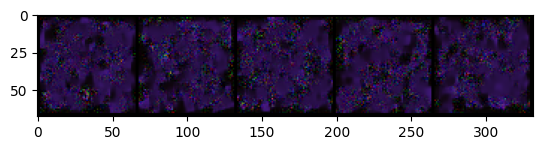

In [8]:
import torchvision

def sample_ddpm(model, num_samples):
    model.eval()
    with torch.no_grad():
        samples = torch.randn(num_samples, 3, 64, 64).cuda()
        for t in range(1000, 0, -1):
            predicted_noise = model(samples, torch.full((num_samples,), t/1000).cuda())
            samples = samples - predicted_noise / 1000  # 更新步驟
    return samples

generated_images = sample_ddpm(ddpm_model, 5)  # 生成5張新圖片

# 轉換為PIL圖片並顯示
generated_images = generated_images.cpu().clamp(0, 1)
grid = torchvision.utils.make_grid(generated_images, nrow=5)
np_grid = grid.numpy().transpose((1, 2, 0))

import matplotlib.pyplot as plt
plt.imshow(np_grid)
plt.show()


### 比較結果

100%|██████████| 223/223 [00:00<00:00, 447.05it/s]


Epoch 1/500, Loss: 0.029446630596680224


100%|██████████| 223/223 [00:00<00:00, 458.73it/s]


Epoch 2/500, Loss: 0.03424534623014152


100%|██████████| 223/223 [00:00<00:00, 458.51it/s]


Epoch 3/500, Loss: 0.031246524141274493


100%|██████████| 223/223 [00:00<00:00, 455.30it/s]


Epoch 4/500, Loss: 0.030450405385929906


100%|██████████| 223/223 [00:00<00:00, 457.87it/s]


Epoch 5/500, Loss: 0.02647832246505626


100%|██████████| 223/223 [00:00<00:00, 451.61it/s]


Epoch 6/500, Loss: 0.031547823824790294


100%|██████████| 223/223 [00:00<00:00, 452.97it/s]


Epoch 7/500, Loss: 0.028088917500535736


100%|██████████| 223/223 [00:00<00:00, 451.58it/s]


Epoch 8/500, Loss: 0.03374503527020392


100%|██████████| 223/223 [00:00<00:00, 457.24it/s]


Epoch 9/500, Loss: 0.028666949004035092


100%|██████████| 223/223 [00:00<00:00, 457.44it/s]


Epoch 10/500, Loss: 0.028674623544741373


100%|██████████| 223/223 [00:00<00:00, 463.52it/s]


Epoch 11/500, Loss: 0.029050255457415443


100%|██████████| 223/223 [00:00<00:00, 461.21it/s]


Epoch 12/500, Loss: 0.03209549096316901


100%|██████████| 223/223 [00:00<00:00, 461.63it/s]


Epoch 13/500, Loss: 0.028849243637458357


100%|██████████| 223/223 [00:00<00:00, 459.48it/s]


Epoch 14/500, Loss: 0.027268798737849355


100%|██████████| 223/223 [00:00<00:00, 459.06it/s]


Epoch 15/500, Loss: 0.027850539214708613


100%|██████████| 223/223 [00:00<00:00, 430.65it/s]


Epoch 16/500, Loss: 0.027597042097137914


100%|██████████| 223/223 [00:00<00:00, 381.76it/s]


Epoch 17/500, Loss: 0.02883024758454663


100%|██████████| 223/223 [00:00<00:00, 400.63it/s]


Epoch 18/500, Loss: 0.029608971881993417


100%|██████████| 223/223 [00:00<00:00, 410.11it/s]


Epoch 19/500, Loss: 0.02942475887441448


100%|██████████| 223/223 [00:00<00:00, 403.80it/s]


Epoch 20/500, Loss: 0.03661047849353119


100%|██████████| 223/223 [00:00<00:00, 388.31it/s]


Epoch 21/500, Loss: 0.033244558417910686


100%|██████████| 223/223 [00:00<00:00, 381.11it/s]


Epoch 22/500, Loss: 0.03133909479034187


100%|██████████| 223/223 [00:00<00:00, 443.12it/s]


Epoch 23/500, Loss: 0.029228553464093282


100%|██████████| 223/223 [00:00<00:00, 457.94it/s]


Epoch 24/500, Loss: 0.026311777089409228


100%|██████████| 223/223 [00:00<00:00, 452.50it/s]


Epoch 25/500, Loss: 0.027811504875397467


100%|██████████| 223/223 [00:00<00:00, 446.85it/s]


Epoch 26/500, Loss: 0.03053425213180048


100%|██████████| 223/223 [00:00<00:00, 453.20it/s]


Epoch 27/500, Loss: 0.029095962326221938


100%|██████████| 223/223 [00:00<00:00, 447.75it/s]


Epoch 28/500, Loss: 0.027128988910349497


100%|██████████| 223/223 [00:00<00:00, 454.65it/s]


Epoch 29/500, Loss: 0.030247441810376172


100%|██████████| 223/223 [00:00<00:00, 455.34it/s]


Epoch 30/500, Loss: 0.030708270761363978


100%|██████████| 223/223 [00:00<00:00, 459.22it/s]


Epoch 31/500, Loss: 0.03081891981408735


100%|██████████| 223/223 [00:00<00:00, 453.99it/s]


Epoch 32/500, Loss: 0.0288417446698509


100%|██████████| 223/223 [00:00<00:00, 463.61it/s]


Epoch 33/500, Loss: 0.03305367735369056


100%|██████████| 223/223 [00:00<00:00, 456.64it/s]


Epoch 34/500, Loss: 0.029842262636586157


100%|██████████| 223/223 [00:00<00:00, 455.86it/s]


Epoch 35/500, Loss: 0.030711740777397637


100%|██████████| 223/223 [00:00<00:00, 457.42it/s]


Epoch 36/500, Loss: 0.034181194960436215


100%|██████████| 223/223 [00:00<00:00, 451.52it/s]


Epoch 37/500, Loss: 0.030141819013708642


100%|██████████| 223/223 [00:00<00:00, 449.11it/s]


Epoch 38/500, Loss: 0.028834479581147033


100%|██████████| 223/223 [00:00<00:00, 459.26it/s]


Epoch 39/500, Loss: 0.035954693023265746


100%|██████████| 223/223 [00:00<00:00, 456.22it/s]


Epoch 40/500, Loss: 0.031457298355920434


100%|██████████| 223/223 [00:00<00:00, 462.68it/s]


Epoch 41/500, Loss: 0.03128588710381178


100%|██████████| 223/223 [00:00<00:00, 444.18it/s]


Epoch 42/500, Loss: 0.026478364708678873


100%|██████████| 223/223 [00:00<00:00, 396.15it/s]


Epoch 43/500, Loss: 0.02697756110101671


100%|██████████| 223/223 [00:00<00:00, 414.31it/s]


Epoch 44/500, Loss: 0.03319455240957539


100%|██████████| 223/223 [00:00<00:00, 401.05it/s]


Epoch 45/500, Loss: 0.03138835142228769


100%|██████████| 223/223 [00:00<00:00, 393.38it/s]


Epoch 46/500, Loss: 0.028502602130174637


100%|██████████| 223/223 [00:00<00:00, 371.49it/s]


Epoch 47/500, Loss: 0.028775280516912048


100%|██████████| 223/223 [00:00<00:00, 350.02it/s]


Epoch 48/500, Loss: 0.027785337784832904


100%|██████████| 223/223 [00:00<00:00, 426.16it/s]


Epoch 49/500, Loss: 0.026149029154414017


100%|██████████| 223/223 [00:00<00:00, 442.08it/s]


Epoch 50/500, Loss: 0.028305297658983368


100%|██████████| 223/223 [00:00<00:00, 448.28it/s]


Epoch 51/500, Loss: 0.028648850863022653


100%|██████████| 223/223 [00:00<00:00, 434.00it/s]


Epoch 52/500, Loss: 0.03484745406349411


100%|██████████| 223/223 [00:00<00:00, 448.62it/s]


Epoch 53/500, Loss: 0.030971048278692324


100%|██████████| 223/223 [00:00<00:00, 448.11it/s]


Epoch 54/500, Loss: 0.026893631154211915


100%|██████████| 223/223 [00:00<00:00, 444.63it/s]


Epoch 55/500, Loss: 0.027337227513671188


100%|██████████| 223/223 [00:00<00:00, 448.38it/s]


Epoch 56/500, Loss: 0.02682054591586504


100%|██████████| 223/223 [00:00<00:00, 454.72it/s]


Epoch 57/500, Loss: 0.03180980278103875


100%|██████████| 223/223 [00:00<00:00, 442.95it/s]


Epoch 58/500, Loss: 0.027209642656448176


100%|██████████| 223/223 [00:00<00:00, 444.68it/s]


Epoch 59/500, Loss: 0.03037112457218325


100%|██████████| 223/223 [00:00<00:00, 449.12it/s]


Epoch 60/500, Loss: 0.03419468738973942


100%|██████████| 223/223 [00:00<00:00, 452.20it/s]


Epoch 61/500, Loss: 0.02960205080213167


100%|██████████| 223/223 [00:00<00:00, 451.23it/s]


Epoch 62/500, Loss: 0.032726483457124554


100%|██████████| 223/223 [00:00<00:00, 459.06it/s]


Epoch 63/500, Loss: 0.028164764394307082


100%|██████████| 223/223 [00:00<00:00, 455.01it/s]


Epoch 64/500, Loss: 0.02939830771375932


100%|██████████| 223/223 [00:00<00:00, 454.78it/s]


Epoch 65/500, Loss: 0.03000099667986947


100%|██████████| 223/223 [00:00<00:00, 450.60it/s]


Epoch 66/500, Loss: 0.02865314844895505


100%|██████████| 223/223 [00:00<00:00, 457.28it/s]


Epoch 67/500, Loss: 0.03254129292418337


100%|██████████| 223/223 [00:00<00:00, 455.42it/s]


Epoch 68/500, Loss: 0.027396115202941166


100%|██████████| 223/223 [00:00<00:00, 402.10it/s]


Epoch 69/500, Loss: 0.02870259328741129


100%|██████████| 223/223 [00:00<00:00, 405.56it/s]


Epoch 70/500, Loss: 0.02916991588713877


100%|██████████| 223/223 [00:00<00:00, 394.28it/s]


Epoch 71/500, Loss: 0.030127620449782486


100%|██████████| 223/223 [00:00<00:00, 388.22it/s]


Epoch 72/500, Loss: 0.02764850656080139


100%|██████████| 223/223 [00:00<00:00, 389.98it/s]


Epoch 73/500, Loss: 0.03047238650727566


100%|██████████| 223/223 [00:00<00:00, 390.54it/s]


Epoch 74/500, Loss: 0.030619953337204832


100%|██████████| 223/223 [00:00<00:00, 408.48it/s]


Epoch 75/500, Loss: 0.027464065805177785


100%|██████████| 223/223 [00:00<00:00, 450.75it/s]


Epoch 76/500, Loss: 0.026970707673596158


100%|██████████| 223/223 [00:00<00:00, 456.18it/s]


Epoch 77/500, Loss: 0.02922613192099092


100%|██████████| 223/223 [00:00<00:00, 456.55it/s]


Epoch 78/500, Loss: 0.03072142538785801


100%|██████████| 223/223 [00:00<00:00, 458.36it/s]


Epoch 79/500, Loss: 0.02796506987375128


100%|██████████| 223/223 [00:00<00:00, 460.17it/s]


Epoch 80/500, Loss: 0.02985334489494562


100%|██████████| 223/223 [00:00<00:00, 456.99it/s]


Epoch 81/500, Loss: 0.03173794059057808


100%|██████████| 223/223 [00:00<00:00, 452.15it/s]


Epoch 82/500, Loss: 0.029931720939251873


100%|██████████| 223/223 [00:00<00:00, 456.06it/s]


Epoch 83/500, Loss: 0.027639678691935645


100%|██████████| 223/223 [00:00<00:00, 445.88it/s]


Epoch 84/500, Loss: 0.029888606763908414


100%|██████████| 223/223 [00:00<00:00, 452.73it/s]


Epoch 85/500, Loss: 0.03259227293305467


100%|██████████| 223/223 [00:00<00:00, 456.56it/s]


Epoch 86/500, Loss: 0.028335483231051353


100%|██████████| 223/223 [00:00<00:00, 458.78it/s]


Epoch 87/500, Loss: 0.034934088813282985


100%|██████████| 223/223 [00:00<00:00, 449.08it/s]


Epoch 88/500, Loss: 0.028122988053401222


100%|██████████| 223/223 [00:00<00:00, 458.76it/s]


Epoch 89/500, Loss: 0.03007844880206569


100%|██████████| 223/223 [00:00<00:00, 454.80it/s]


Epoch 90/500, Loss: 0.024002995392132232


100%|██████████| 223/223 [00:00<00:00, 458.19it/s]


Epoch 91/500, Loss: 0.031089151679066264


100%|██████████| 223/223 [00:00<00:00, 452.75it/s]


Epoch 92/500, Loss: 0.028116244597218495


100%|██████████| 223/223 [00:00<00:00, 442.47it/s]


Epoch 93/500, Loss: 0.033320738670871396


100%|██████████| 223/223 [00:00<00:00, 443.44it/s]


Epoch 94/500, Loss: 0.031421808003878116


100%|██████████| 223/223 [00:00<00:00, 403.97it/s]


Epoch 95/500, Loss: 0.028137894510187108


100%|██████████| 223/223 [00:00<00:00, 402.91it/s]


Epoch 96/500, Loss: 0.032923395231767086


100%|██████████| 223/223 [00:00<00:00, 399.27it/s]


Epoch 97/500, Loss: 0.026375788456087956


100%|██████████| 223/223 [00:00<00:00, 414.16it/s]


Epoch 98/500, Loss: 0.029644231950956074


100%|██████████| 223/223 [00:00<00:00, 411.90it/s]


Epoch 99/500, Loss: 0.032426795529644316


100%|██████████| 223/223 [00:00<00:00, 369.50it/s]


Epoch 100/500, Loss: 0.02672569624945989


100%|██████████| 223/223 [00:00<00:00, 395.17it/s]


Epoch 101/500, Loss: 0.02891403333087673


100%|██████████| 223/223 [00:00<00:00, 456.10it/s]


Epoch 102/500, Loss: 0.02758974897687745


100%|██████████| 223/223 [00:00<00:00, 454.47it/s]


Epoch 103/500, Loss: 0.034751023867505816


100%|██████████| 223/223 [00:00<00:00, 451.70it/s]


Epoch 104/500, Loss: 0.03020627148900465


100%|██████████| 223/223 [00:00<00:00, 458.06it/s]


Epoch 105/500, Loss: 0.029843292654295674


100%|██████████| 223/223 [00:00<00:00, 455.50it/s]


Epoch 106/500, Loss: 0.03319189928037703


100%|██████████| 223/223 [00:00<00:00, 454.94it/s]


Epoch 107/500, Loss: 0.031528228534711315


100%|██████████| 223/223 [00:00<00:00, 449.45it/s]


Epoch 108/500, Loss: 0.0322234561925779


100%|██████████| 223/223 [00:00<00:00, 455.63it/s]


Epoch 109/500, Loss: 0.02358508396960561


100%|██████████| 223/223 [00:00<00:00, 449.69it/s]


Epoch 110/500, Loss: 0.028981957434271483


100%|██████████| 223/223 [00:00<00:00, 458.75it/s]


Epoch 111/500, Loss: 0.030490888487297058


100%|██████████| 223/223 [00:00<00:00, 454.46it/s]


Epoch 112/500, Loss: 0.028896440096166102


100%|██████████| 223/223 [00:00<00:00, 450.71it/s]


Epoch 113/500, Loss: 0.030904692505807886


100%|██████████| 223/223 [00:00<00:00, 451.91it/s]


Epoch 114/500, Loss: 0.025837805410304143


100%|██████████| 223/223 [00:00<00:00, 457.98it/s]


Epoch 115/500, Loss: 0.026150046459361576


100%|██████████| 223/223 [00:00<00:00, 452.04it/s]


Epoch 116/500, Loss: 0.02934712740371313


100%|██████████| 223/223 [00:00<00:00, 454.29it/s]


Epoch 117/500, Loss: 0.0325638865258528


100%|██████████| 223/223 [00:00<00:00, 444.88it/s]


Epoch 118/500, Loss: 0.031431296685785724


100%|██████████| 223/223 [00:00<00:00, 456.26it/s]


Epoch 119/500, Loss: 0.030964146689783298


100%|██████████| 223/223 [00:00<00:00, 452.56it/s]


Epoch 120/500, Loss: 0.0283345717084782


100%|██████████| 223/223 [00:00<00:00, 447.85it/s]


Epoch 121/500, Loss: 0.026968983219176398


100%|██████████| 223/223 [00:00<00:00, 398.36it/s]


Epoch 122/500, Loss: 0.028599912664047003


100%|██████████| 223/223 [00:00<00:00, 421.04it/s]


Epoch 123/500, Loss: 0.029441600322990674


100%|██████████| 223/223 [00:00<00:00, 396.20it/s]


Epoch 124/500, Loss: 0.028566324189639412


100%|██████████| 223/223 [00:00<00:00, 420.13it/s]


Epoch 125/500, Loss: 0.02510111937675241


100%|██████████| 223/223 [00:00<00:00, 398.87it/s]


Epoch 126/500, Loss: 0.030285979583525337


100%|██████████| 223/223 [00:00<00:00, 394.72it/s]


Epoch 127/500, Loss: 0.035119829582459725


100%|██████████| 223/223 [00:00<00:00, 410.16it/s]


Epoch 128/500, Loss: 0.031771227262179146


100%|██████████| 223/223 [00:00<00:00, 453.17it/s]


Epoch 129/500, Loss: 0.02936860014404684


100%|██████████| 223/223 [00:00<00:00, 454.58it/s]


Epoch 130/500, Loss: 0.029325748756193794


100%|██████████| 223/223 [00:00<00:00, 455.39it/s]


Epoch 131/500, Loss: 0.03132614113323624


100%|██████████| 223/223 [00:00<00:00, 452.29it/s]


Epoch 132/500, Loss: 0.03142344316409174


100%|██████████| 223/223 [00:00<00:00, 441.72it/s]


Epoch 133/500, Loss: 0.028455339927610526


100%|██████████| 223/223 [00:00<00:00, 454.13it/s]


Epoch 134/500, Loss: 0.03492905199945374


100%|██████████| 223/223 [00:00<00:00, 458.87it/s]


Epoch 135/500, Loss: 0.03232436975038239


100%|██████████| 223/223 [00:00<00:00, 446.67it/s]


Epoch 136/500, Loss: 0.030307874225514352


100%|██████████| 223/223 [00:00<00:00, 451.36it/s]


Epoch 137/500, Loss: 0.026388410645883716


100%|██████████| 223/223 [00:00<00:00, 451.92it/s]


Epoch 138/500, Loss: 0.02555885757716381


100%|██████████| 223/223 [00:00<00:00, 454.50it/s]


Epoch 139/500, Loss: 0.02835987908807437


100%|██████████| 223/223 [00:00<00:00, 445.88it/s]


Epoch 140/500, Loss: 0.03246694545140448


100%|██████████| 223/223 [00:00<00:00, 458.00it/s]


Epoch 141/500, Loss: 0.025841210726565044


100%|██████████| 223/223 [00:00<00:00, 441.62it/s]


Epoch 142/500, Loss: 0.03300768544588388


100%|██████████| 223/223 [00:00<00:00, 456.96it/s]


Epoch 143/500, Loss: 0.027327664551479666


100%|██████████| 223/223 [00:00<00:00, 449.63it/s]


Epoch 144/500, Loss: 0.029098331815492144


100%|██████████| 223/223 [00:00<00:00, 446.60it/s]


Epoch 145/500, Loss: 0.029125589321914544


100%|██████████| 223/223 [00:00<00:00, 440.54it/s]


Epoch 146/500, Loss: 0.030683342421703008


100%|██████████| 223/223 [00:00<00:00, 452.65it/s]


Epoch 147/500, Loss: 0.032216390473726354


100%|██████████| 223/223 [00:00<00:00, 399.81it/s]


Epoch 148/500, Loss: 0.029316545380571764


100%|██████████| 223/223 [00:00<00:00, 404.12it/s]


Epoch 149/500, Loss: 0.02786575965666851


100%|██████████| 223/223 [00:00<00:00, 395.99it/s]


Epoch 150/500, Loss: 0.03375268522900583


100%|██████████| 223/223 [00:00<00:00, 420.01it/s]


Epoch 151/500, Loss: 0.02463516145694015


100%|██████████| 223/223 [00:00<00:00, 414.70it/s]


Epoch 152/500, Loss: 0.027578570925935502


100%|██████████| 223/223 [00:00<00:00, 384.04it/s]


Epoch 153/500, Loss: 0.032015401331265146


100%|██████████| 223/223 [00:00<00:00, 384.78it/s]


Epoch 154/500, Loss: 0.032299609771290705


100%|██████████| 223/223 [00:00<00:00, 449.28it/s]


Epoch 155/500, Loss: 0.027727438032526874


100%|██████████| 223/223 [00:00<00:00, 455.78it/s]


Epoch 156/500, Loss: 0.029585679070063504


100%|██████████| 223/223 [00:00<00:00, 458.20it/s]


Epoch 157/500, Loss: 0.03193457288492153


100%|██████████| 223/223 [00:00<00:00, 446.23it/s]


Epoch 158/500, Loss: 0.025054595228535176


100%|██████████| 223/223 [00:00<00:00, 453.11it/s]


Epoch 159/500, Loss: 0.02826634734752066


100%|██████████| 223/223 [00:00<00:00, 447.29it/s]


Epoch 160/500, Loss: 0.03351267706602812


100%|██████████| 223/223 [00:00<00:00, 454.97it/s]


Epoch 161/500, Loss: 0.029872423848095495


100%|██████████| 223/223 [00:00<00:00, 443.92it/s]


Epoch 162/500, Loss: 0.02890382246469302


100%|██████████| 223/223 [00:00<00:00, 446.21it/s]


Epoch 163/500, Loss: 0.03312301292447498


100%|██████████| 223/223 [00:00<00:00, 439.34it/s]


Epoch 164/500, Loss: 0.027656128630042076


100%|██████████| 223/223 [00:00<00:00, 451.26it/s]


Epoch 165/500, Loss: 0.028380620706776334


100%|██████████| 223/223 [00:00<00:00, 448.76it/s]


Epoch 166/500, Loss: 0.03618038006778389


100%|██████████| 223/223 [00:00<00:00, 452.72it/s]


Epoch 167/500, Loss: 0.03215598814072497


100%|██████████| 223/223 [00:00<00:00, 448.79it/s]


Epoch 168/500, Loss: 0.029937490674713


100%|██████████| 223/223 [00:00<00:00, 455.95it/s]


Epoch 169/500, Loss: 0.028976521070528727


100%|██████████| 223/223 [00:00<00:00, 448.45it/s]


Epoch 170/500, Loss: 0.02444084802634112


100%|██████████| 223/223 [00:00<00:00, 452.66it/s]


Epoch 171/500, Loss: 0.028540996400296954


100%|██████████| 223/223 [00:00<00:00, 450.95it/s]


Epoch 172/500, Loss: 0.027476473661315014


100%|██████████| 223/223 [00:00<00:00, 450.06it/s]


Epoch 173/500, Loss: 0.027268290503009017


100%|██████████| 223/223 [00:00<00:00, 424.49it/s]


Epoch 174/500, Loss: 0.03142177171153204


100%|██████████| 223/223 [00:00<00:00, 400.46it/s]


Epoch 175/500, Loss: 0.028511482136399223


100%|██████████| 223/223 [00:00<00:00, 388.09it/s]


Epoch 176/500, Loss: 0.034560409545764795


100%|██████████| 223/223 [00:00<00:00, 416.95it/s]


Epoch 177/500, Loss: 0.0281142235812919


100%|██████████| 223/223 [00:00<00:00, 418.30it/s]


Epoch 178/500, Loss: 0.0346963703172958


100%|██████████| 223/223 [00:00<00:00, 387.26it/s]


Epoch 179/500, Loss: 0.028214973547901007


100%|██████████| 223/223 [00:00<00:00, 387.37it/s]


Epoch 180/500, Loss: 0.025278743728160056


100%|██████████| 223/223 [00:00<00:00, 446.59it/s]


Epoch 181/500, Loss: 0.03014232554460454


100%|██████████| 223/223 [00:00<00:00, 453.57it/s]


Epoch 182/500, Loss: 0.027353132519486775


100%|██████████| 223/223 [00:00<00:00, 449.11it/s]


Epoch 183/500, Loss: 0.02950953536420526


100%|██████████| 223/223 [00:00<00:00, 456.19it/s]


Epoch 184/500, Loss: 0.03111649252424192


100%|██████████| 223/223 [00:00<00:00, 455.54it/s]


Epoch 185/500, Loss: 0.027804832241493757


100%|██████████| 223/223 [00:00<00:00, 454.90it/s]


Epoch 186/500, Loss: 0.028993827528884058


100%|██████████| 223/223 [00:00<00:00, 454.85it/s]


Epoch 187/500, Loss: 0.029448090451080437


100%|██████████| 223/223 [00:00<00:00, 445.70it/s]


Epoch 188/500, Loss: 0.02383212868391532


100%|██████████| 223/223 [00:00<00:00, 446.54it/s]


Epoch 189/500, Loss: 0.02681154656253187


100%|██████████| 223/223 [00:00<00:00, 447.33it/s]


Epoch 190/500, Loss: 0.028870293452934834


100%|██████████| 223/223 [00:00<00:00, 455.94it/s]


Epoch 191/500, Loss: 0.029640554295927955


100%|██████████| 223/223 [00:00<00:00, 427.93it/s]


Epoch 192/500, Loss: 0.03004926702867976


100%|██████████| 223/223 [00:00<00:00, 448.50it/s]


Epoch 193/500, Loss: 0.03072951649286421


100%|██████████| 223/223 [00:00<00:00, 449.70it/s]


Epoch 194/500, Loss: 0.041616695081071735


100%|██████████| 223/223 [00:00<00:00, 460.62it/s]


Epoch 195/500, Loss: 0.03241617446389434


100%|██████████| 223/223 [00:00<00:00, 447.85it/s]


Epoch 196/500, Loss: 0.02811893339231276


100%|██████████| 223/223 [00:00<00:00, 448.34it/s]


Epoch 197/500, Loss: 0.028745274819567332


100%|██████████| 223/223 [00:00<00:00, 444.00it/s]


Epoch 198/500, Loss: 0.026196704170929744


100%|██████████| 223/223 [00:00<00:00, 458.65it/s]


Epoch 199/500, Loss: 0.02764480804080653


100%|██████████| 223/223 [00:00<00:00, 452.70it/s]


Epoch 200/500, Loss: 0.02705744428000509


100%|██████████| 223/223 [00:00<00:00, 405.43it/s]


Epoch 201/500, Loss: 0.02895070066166031


100%|██████████| 223/223 [00:00<00:00, 413.87it/s]


Epoch 202/500, Loss: 0.03177088934660893


100%|██████████| 223/223 [00:00<00:00, 400.06it/s]


Epoch 203/500, Loss: 0.024489464029469298


100%|██████████| 223/223 [00:00<00:00, 396.15it/s]


Epoch 204/500, Loss: 0.025907001754628168


100%|██████████| 223/223 [00:00<00:00, 372.29it/s]


Epoch 205/500, Loss: 0.04299423147844894


100%|██████████| 223/223 [00:00<00:00, 386.30it/s]


Epoch 206/500, Loss: 0.036202755376629765


100%|██████████| 223/223 [00:00<00:00, 390.24it/s]


Epoch 207/500, Loss: 0.030499608180748775


100%|██████████| 223/223 [00:00<00:00, 450.73it/s]


Epoch 208/500, Loss: 0.03097354654523423


100%|██████████| 223/223 [00:00<00:00, 448.27it/s]


Epoch 209/500, Loss: 0.02718801191285453


100%|██████████| 223/223 [00:00<00:00, 453.15it/s]


Epoch 210/500, Loss: 0.030785134262635034


100%|██████████| 223/223 [00:00<00:00, 453.60it/s]


Epoch 211/500, Loss: 0.032596078613614285


100%|██████████| 223/223 [00:00<00:00, 454.10it/s]


Epoch 212/500, Loss: 0.028483775135280037


100%|██████████| 223/223 [00:00<00:00, 451.67it/s]


Epoch 213/500, Loss: 0.02762682871650821


100%|██████████| 223/223 [00:00<00:00, 461.94it/s]


Epoch 214/500, Loss: 0.0254321330991227


100%|██████████| 223/223 [00:00<00:00, 456.19it/s]


Epoch 215/500, Loss: 0.028182734839718438


100%|██████████| 223/223 [00:00<00:00, 455.20it/s]


Epoch 216/500, Loss: 0.029289909801341493


100%|██████████| 223/223 [00:00<00:00, 449.27it/s]


Epoch 217/500, Loss: 0.028709695269374568


100%|██████████| 223/223 [00:00<00:00, 452.71it/s]


Epoch 218/500, Loss: 0.024341506461692232


100%|██████████| 223/223 [00:00<00:00, 453.86it/s]


Epoch 219/500, Loss: 0.027279346826331766


100%|██████████| 223/223 [00:00<00:00, 454.10it/s]


Epoch 220/500, Loss: 0.028489856203942822


100%|██████████| 223/223 [00:00<00:00, 445.05it/s]


Epoch 221/500, Loss: 0.027440314214559683


100%|██████████| 223/223 [00:00<00:00, 454.68it/s]


Epoch 222/500, Loss: 0.03167185515182034


100%|██████████| 223/223 [00:00<00:00, 457.76it/s]


Epoch 223/500, Loss: 0.03002018242189034


100%|██████████| 223/223 [00:00<00:00, 446.45it/s]


Epoch 224/500, Loss: 0.030296962006610605


100%|██████████| 223/223 [00:00<00:00, 447.60it/s]


Epoch 225/500, Loss: 0.02697604367167025


100%|██████████| 223/223 [00:00<00:00, 449.12it/s]


Epoch 226/500, Loss: 0.03027154009521943


100%|██████████| 223/223 [00:00<00:00, 435.47it/s]


Epoch 227/500, Loss: 0.027267444235661104


100%|██████████| 223/223 [00:00<00:00, 397.99it/s]


Epoch 228/500, Loss: 0.029094528707554523


100%|██████████| 223/223 [00:00<00:00, 408.73it/s]


Epoch 229/500, Loss: 0.03294452326163449


100%|██████████| 223/223 [00:00<00:00, 416.24it/s]


Epoch 230/500, Loss: 0.03205312001665077


100%|██████████| 223/223 [00:00<00:00, 405.88it/s]


Epoch 231/500, Loss: 0.03116784509555374


100%|██████████| 223/223 [00:00<00:00, 383.05it/s]


Epoch 232/500, Loss: 0.02952252410251998


100%|██████████| 223/223 [00:00<00:00, 373.93it/s]


Epoch 233/500, Loss: 0.02799844354675089


100%|██████████| 223/223 [00:00<00:00, 422.78it/s]


Epoch 234/500, Loss: 0.02750163124832471


100%|██████████| 223/223 [00:00<00:00, 447.20it/s]


Epoch 235/500, Loss: 0.027739968581016555


100%|██████████| 223/223 [00:00<00:00, 453.55it/s]


Epoch 236/500, Loss: 0.030222372611308043


100%|██████████| 223/223 [00:00<00:00, 446.27it/s]


Epoch 237/500, Loss: 0.02711574602120393


100%|██████████| 223/223 [00:00<00:00, 454.31it/s]


Epoch 238/500, Loss: 0.02937313634066972


100%|██████████| 223/223 [00:00<00:00, 448.92it/s]


Epoch 239/500, Loss: 0.025880610211146786


100%|██████████| 223/223 [00:00<00:00, 461.48it/s]


Epoch 240/500, Loss: 0.030472830201043945


100%|██████████| 223/223 [00:00<00:00, 450.33it/s]


Epoch 241/500, Loss: 0.025300571398450388


100%|██████████| 223/223 [00:00<00:00, 453.56it/s]


Epoch 242/500, Loss: 0.02895858912256801


100%|██████████| 223/223 [00:00<00:00, 445.74it/s]


Epoch 243/500, Loss: 0.027770314490915413


100%|██████████| 223/223 [00:00<00:00, 447.56it/s]


Epoch 244/500, Loss: 0.02951434791722907


100%|██████████| 223/223 [00:00<00:00, 447.32it/s]


Epoch 245/500, Loss: 0.03310601068284747


100%|██████████| 223/223 [00:00<00:00, 455.06it/s]


Epoch 246/500, Loss: 0.02746072735620721


100%|██████████| 223/223 [00:00<00:00, 450.75it/s]


Epoch 247/500, Loss: 0.0283060246042807


100%|██████████| 223/223 [00:00<00:00, 451.77it/s]


Epoch 248/500, Loss: 0.02756283902918143


100%|██████████| 223/223 [00:00<00:00, 447.17it/s]


Epoch 249/500, Loss: 0.029223901512009414


100%|██████████| 223/223 [00:00<00:00, 431.41it/s]


Epoch 250/500, Loss: 0.030776437551551603


100%|██████████| 223/223 [00:00<00:00, 448.08it/s]


Epoch 251/500, Loss: 0.03333845142392032


100%|██████████| 223/223 [00:00<00:00, 446.92it/s]


Epoch 252/500, Loss: 0.033607050997827355


100%|██████████| 223/223 [00:00<00:00, 441.66it/s]


Epoch 253/500, Loss: 0.03113122020468049


100%|██████████| 223/223 [00:00<00:00, 407.86it/s]


Epoch 254/500, Loss: 0.02566872036811215


100%|██████████| 223/223 [00:00<00:00, 414.83it/s]


Epoch 255/500, Loss: 0.027415374281394376


100%|██████████| 223/223 [00:00<00:00, 391.86it/s]


Epoch 256/500, Loss: 0.027879070753707748


100%|██████████| 223/223 [00:00<00:00, 388.29it/s]


Epoch 257/500, Loss: 0.03323428009974983


100%|██████████| 223/223 [00:00<00:00, 415.32it/s]


Epoch 258/500, Loss: 0.02880711022413632


100%|██████████| 223/223 [00:00<00:00, 386.12it/s]


Epoch 259/500, Loss: 0.024663663314730598


100%|██████████| 223/223 [00:00<00:00, 385.75it/s]


Epoch 260/500, Loss: 0.030129303145034432


100%|██████████| 223/223 [00:00<00:00, 446.23it/s]


Epoch 261/500, Loss: 0.0354142665587399


100%|██████████| 223/223 [00:00<00:00, 437.78it/s]


Epoch 262/500, Loss: 0.024397780630119447


100%|██████████| 223/223 [00:00<00:00, 450.66it/s]


Epoch 263/500, Loss: 0.025849761036245544


100%|██████████| 223/223 [00:00<00:00, 454.43it/s]


Epoch 264/500, Loss: 0.029076023010595496


100%|██████████| 223/223 [00:00<00:00, 447.79it/s]


Epoch 265/500, Loss: 0.02632168586044301


100%|██████████| 223/223 [00:00<00:00, 456.93it/s]


Epoch 266/500, Loss: 0.028688008851066833


100%|██████████| 223/223 [00:00<00:00, 446.11it/s]


Epoch 267/500, Loss: 0.02636316322174441


100%|██████████| 223/223 [00:00<00:00, 453.89it/s]


Epoch 268/500, Loss: 0.028851181043169957


100%|██████████| 223/223 [00:00<00:00, 450.27it/s]


Epoch 269/500, Loss: 0.027523941727931458


100%|██████████| 223/223 [00:00<00:00, 451.54it/s]


Epoch 270/500, Loss: 0.02777561300221179


100%|██████████| 223/223 [00:00<00:00, 446.91it/s]


Epoch 271/500, Loss: 0.03251357744510532


100%|██████████| 223/223 [00:00<00:00, 454.58it/s]


Epoch 272/500, Loss: 0.02858637008532013


100%|██████████| 223/223 [00:00<00:00, 439.87it/s]


Epoch 273/500, Loss: 0.027279921832406736


100%|██████████| 223/223 [00:00<00:00, 450.08it/s]


Epoch 274/500, Loss: 0.0262376733934465


100%|██████████| 223/223 [00:00<00:00, 452.61it/s]


Epoch 275/500, Loss: 0.03007475210712897


100%|██████████| 223/223 [00:00<00:00, 455.23it/s]


Epoch 276/500, Loss: 0.029989293383877107


100%|██████████| 223/223 [00:00<00:00, 450.26it/s]


Epoch 277/500, Loss: 0.029464762536767084


100%|██████████| 223/223 [00:00<00:00, 453.54it/s]


Epoch 278/500, Loss: 0.028149778624754315


100%|██████████| 223/223 [00:00<00:00, 428.04it/s]


Epoch 279/500, Loss: 0.033935932037441455


100%|██████████| 223/223 [00:00<00:00, 412.05it/s]


Epoch 280/500, Loss: 0.027974843770065115


100%|██████████| 223/223 [00:00<00:00, 399.91it/s]


Epoch 281/500, Loss: 0.027788348592015927


100%|██████████| 223/223 [00:00<00:00, 384.47it/s]


Epoch 282/500, Loss: 0.02359796171765691


100%|██████████| 223/223 [00:00<00:00, 392.61it/s]


Epoch 283/500, Loss: 0.03125403700772288


100%|██████████| 223/223 [00:00<00:00, 418.82it/s]


Epoch 284/500, Loss: 0.02889212565872434


100%|██████████| 223/223 [00:00<00:00, 379.75it/s]


Epoch 285/500, Loss: 0.03375361655993312


100%|██████████| 223/223 [00:00<00:00, 381.31it/s]


Epoch 286/500, Loss: 0.02756853748714309


100%|██████████| 223/223 [00:00<00:00, 433.61it/s]


Epoch 287/500, Loss: 0.03114182982309784


100%|██████████| 223/223 [00:00<00:00, 451.47it/s]


Epoch 288/500, Loss: 0.026213193646394083


100%|██████████| 223/223 [00:00<00:00, 452.42it/s]


Epoch 289/500, Loss: 0.02538295507414325


100%|██████████| 223/223 [00:00<00:00, 447.07it/s]


Epoch 290/500, Loss: 0.03480604333143197


100%|██████████| 223/223 [00:00<00:00, 446.63it/s]


Epoch 291/500, Loss: 0.027083818926037426


100%|██████████| 223/223 [00:00<00:00, 445.35it/s]


Epoch 292/500, Loss: 0.03262337701470328


100%|██████████| 223/223 [00:00<00:00, 449.27it/s]


Epoch 293/500, Loss: 0.02389912900719541


100%|██████████| 223/223 [00:00<00:00, 448.22it/s]


Epoch 294/500, Loss: 0.032413137224690795


100%|██████████| 223/223 [00:00<00:00, 444.69it/s]


Epoch 295/500, Loss: 0.03332375744232415


100%|██████████| 223/223 [00:00<00:00, 447.87it/s]


Epoch 296/500, Loss: 0.028305047605136587


100%|██████████| 223/223 [00:00<00:00, 446.28it/s]


Epoch 297/500, Loss: 0.02691377306382084


100%|██████████| 223/223 [00:00<00:00, 447.75it/s]


Epoch 298/500, Loss: 0.026094134203722124


100%|██████████| 223/223 [00:00<00:00, 444.95it/s]


Epoch 299/500, Loss: 0.0350545281335511


100%|██████████| 223/223 [00:00<00:00, 454.95it/s]


Epoch 300/500, Loss: 0.027255432596722525


100%|██████████| 223/223 [00:00<00:00, 447.01it/s]


Epoch 301/500, Loss: 0.022455288610951515


100%|██████████| 223/223 [00:00<00:00, 447.57it/s]


Epoch 302/500, Loss: 0.029784269610027295


100%|██████████| 223/223 [00:00<00:00, 445.43it/s]


Epoch 303/500, Loss: 0.029978063041051942


100%|██████████| 223/223 [00:00<00:00, 452.37it/s]


Epoch 304/500, Loss: 0.026563860229613268


100%|██████████| 223/223 [00:00<00:00, 449.95it/s]


Epoch 305/500, Loss: 0.02709803528114819


100%|██████████| 223/223 [00:00<00:00, 446.55it/s]


Epoch 306/500, Loss: 0.03558208461383132


100%|██████████| 223/223 [00:00<00:00, 396.70it/s]


Epoch 307/500, Loss: 0.029356815346888363


100%|██████████| 223/223 [00:00<00:00, 402.16it/s]


Epoch 308/500, Loss: 0.027746578519788023


100%|██████████| 223/223 [00:00<00:00, 378.35it/s]


Epoch 309/500, Loss: 0.026018812087251732


100%|██████████| 223/223 [00:00<00:00, 390.97it/s]


Epoch 310/500, Loss: 0.024494756835892865


100%|██████████| 223/223 [00:00<00:00, 387.90it/s]


Epoch 311/500, Loss: 0.02647584129225112


100%|██████████| 223/223 [00:00<00:00, 375.38it/s]


Epoch 312/500, Loss: 0.030744342626210286


100%|██████████| 223/223 [00:00<00:00, 392.03it/s]


Epoch 313/500, Loss: 0.028790122946315014


100%|██████████| 223/223 [00:00<00:00, 440.74it/s]


Epoch 314/500, Loss: 0.025125153396161684


100%|██████████| 223/223 [00:00<00:00, 438.86it/s]


Epoch 315/500, Loss: 0.02479009051711169


100%|██████████| 223/223 [00:00<00:00, 448.04it/s]


Epoch 316/500, Loss: 0.0364634979081929


100%|██████████| 223/223 [00:00<00:00, 445.70it/s]


Epoch 317/500, Loss: 0.026476002436114535


100%|██████████| 223/223 [00:00<00:00, 450.51it/s]


Epoch 318/500, Loss: 0.028182114040136604


100%|██████████| 223/223 [00:00<00:00, 451.42it/s]


Epoch 319/500, Loss: 0.027087449568069036


100%|██████████| 223/223 [00:00<00:00, 431.44it/s]


Epoch 320/500, Loss: 0.0273864555544316


100%|██████████| 223/223 [00:00<00:00, 452.29it/s]


Epoch 321/500, Loss: 0.028320545614634395


100%|██████████| 223/223 [00:00<00:00, 447.64it/s]


Epoch 322/500, Loss: 0.028202025370146128


100%|██████████| 223/223 [00:00<00:00, 455.20it/s]


Epoch 323/500, Loss: 0.030513025477795858


100%|██████████| 223/223 [00:00<00:00, 450.30it/s]


Epoch 324/500, Loss: 0.02883917166780463


100%|██████████| 223/223 [00:00<00:00, 451.51it/s]


Epoch 325/500, Loss: 0.03148768378229553


100%|██████████| 223/223 [00:00<00:00, 451.17it/s]


Epoch 326/500, Loss: 0.02793818724345867


100%|██████████| 223/223 [00:00<00:00, 455.79it/s]


Epoch 327/500, Loss: 0.02682930322556084


100%|██████████| 223/223 [00:00<00:00, 448.49it/s]


Epoch 328/500, Loss: 0.0315324276426782


100%|██████████| 223/223 [00:00<00:00, 455.82it/s]


Epoch 329/500, Loss: 0.0350787886815154


100%|██████████| 223/223 [00:00<00:00, 452.70it/s]


Epoch 330/500, Loss: 0.025728456308488887


100%|██████████| 223/223 [00:00<00:00, 454.19it/s]


Epoch 331/500, Loss: 0.027769664695043734


100%|██████████| 223/223 [00:00<00:00, 443.48it/s]


Epoch 332/500, Loss: 0.02959606654507697


100%|██████████| 223/223 [00:00<00:00, 401.35it/s]


Epoch 333/500, Loss: 0.030389056010631167


100%|██████████| 223/223 [00:00<00:00, 420.92it/s]


Epoch 334/500, Loss: 0.03023519745355497


100%|██████████| 223/223 [00:00<00:00, 396.59it/s]


Epoch 335/500, Loss: 0.029714085458205686


100%|██████████| 223/223 [00:00<00:00, 402.02it/s]


Epoch 336/500, Loss: 0.03163070413764282


100%|██████████| 223/223 [00:00<00:00, 403.63it/s]


Epoch 337/500, Loss: 0.025102909328624808


100%|██████████| 223/223 [00:00<00:00, 383.06it/s]


Epoch 338/500, Loss: 0.034847845444497504


100%|██████████| 223/223 [00:00<00:00, 385.45it/s]


Epoch 339/500, Loss: 0.02801859602666222


100%|██████████| 223/223 [00:00<00:00, 455.28it/s]


Epoch 340/500, Loss: 0.027954605165785473


100%|██████████| 223/223 [00:00<00:00, 458.44it/s]


Epoch 341/500, Loss: 0.03407162241637707


100%|██████████| 223/223 [00:00<00:00, 451.76it/s]


Epoch 342/500, Loss: 0.029261251247483785


100%|██████████| 223/223 [00:00<00:00, 453.47it/s]


Epoch 343/500, Loss: 0.030423058748178418


100%|██████████| 223/223 [00:00<00:00, 450.62it/s]


Epoch 344/500, Loss: 0.029000705934960746


100%|██████████| 223/223 [00:00<00:00, 455.39it/s]


Epoch 345/500, Loss: 0.02906253963976163


100%|██████████| 223/223 [00:00<00:00, 448.24it/s]


Epoch 346/500, Loss: 0.02586212586360929


100%|██████████| 223/223 [00:00<00:00, 449.41it/s]


Epoch 347/500, Loss: 0.025471058853739046


100%|██████████| 223/223 [00:00<00:00, 448.08it/s]


Epoch 348/500, Loss: 0.031235087420707863


100%|██████████| 223/223 [00:00<00:00, 452.64it/s]


Epoch 349/500, Loss: 0.02446571666112529


100%|██████████| 223/223 [00:00<00:00, 447.72it/s]


Epoch 350/500, Loss: 0.03046708556117632


100%|██████████| 223/223 [00:00<00:00, 452.32it/s]


Epoch 351/500, Loss: 0.02970640223907649


100%|██████████| 223/223 [00:00<00:00, 443.75it/s]


Epoch 352/500, Loss: 0.026318448069484513


100%|██████████| 223/223 [00:00<00:00, 446.68it/s]


Epoch 353/500, Loss: 0.027510139151505558


100%|██████████| 223/223 [00:00<00:00, 447.91it/s]


Epoch 354/500, Loss: 0.028375302996870647


100%|██████████| 223/223 [00:00<00:00, 456.09it/s]


Epoch 355/500, Loss: 0.029289268575308034


100%|██████████| 223/223 [00:00<00:00, 449.06it/s]


Epoch 356/500, Loss: 0.023368640205584833


100%|██████████| 223/223 [00:00<00:00, 451.49it/s]


Epoch 357/500, Loss: 0.028756300371658106


100%|██████████| 223/223 [00:00<00:00, 440.62it/s]


Epoch 358/500, Loss: 0.028342017085362443


100%|██████████| 223/223 [00:00<00:00, 422.29it/s]


Epoch 359/500, Loss: 0.028014717531712065


100%|██████████| 223/223 [00:00<00:00, 390.60it/s]


Epoch 360/500, Loss: 0.028172978283545095


100%|██████████| 223/223 [00:00<00:00, 412.57it/s]


Epoch 361/500, Loss: 0.026451891250574268


100%|██████████| 223/223 [00:00<00:00, 384.69it/s]


Epoch 362/500, Loss: 0.02934158205434747


100%|██████████| 223/223 [00:00<00:00, 410.65it/s]


Epoch 363/500, Loss: 0.029537255591775537


100%|██████████| 223/223 [00:00<00:00, 392.01it/s]


Epoch 364/500, Loss: 0.031101908923164345


100%|██████████| 223/223 [00:00<00:00, 373.81it/s]


Epoch 365/500, Loss: 0.03185673671536515


100%|██████████| 223/223 [00:00<00:00, 386.79it/s]


Epoch 366/500, Loss: 0.028226177525527005


100%|██████████| 223/223 [00:00<00:00, 446.24it/s]


Epoch 367/500, Loss: 0.026959045284799397


100%|██████████| 223/223 [00:00<00:00, 455.29it/s]


Epoch 368/500, Loss: 0.02714825727279411


100%|██████████| 223/223 [00:00<00:00, 448.26it/s]


Epoch 369/500, Loss: 0.031807689547471936


100%|██████████| 223/223 [00:00<00:00, 446.77it/s]


Epoch 370/500, Loss: 0.02805269474055067


100%|██████████| 223/223 [00:00<00:00, 440.08it/s]


Epoch 371/500, Loss: 0.02656712997788271


100%|██████████| 223/223 [00:00<00:00, 455.98it/s]


Epoch 372/500, Loss: 0.02737625454022077


100%|██████████| 223/223 [00:00<00:00, 445.44it/s]


Epoch 373/500, Loss: 0.030663650203078586


100%|██████████| 223/223 [00:00<00:00, 445.28it/s]


Epoch 374/500, Loss: 0.030455036723627104


100%|██████████| 223/223 [00:00<00:00, 444.03it/s]


Epoch 375/500, Loss: 0.026172011288826777


100%|██████████| 223/223 [00:00<00:00, 441.64it/s]


Epoch 376/500, Loss: 0.02787787240883962


100%|██████████| 223/223 [00:00<00:00, 445.96it/s]


Epoch 377/500, Loss: 0.027798996465656523


100%|██████████| 223/223 [00:00<00:00, 421.91it/s]


Epoch 378/500, Loss: 0.03472253349463501


100%|██████████| 223/223 [00:00<00:00, 446.93it/s]


Epoch 379/500, Loss: 0.034610894704947555


100%|██████████| 223/223 [00:00<00:00, 446.13it/s]


Epoch 380/500, Loss: 0.026926053332941683


100%|██████████| 223/223 [00:00<00:00, 455.15it/s]


Epoch 381/500, Loss: 0.028208415537671658


100%|██████████| 223/223 [00:00<00:00, 453.86it/s]


Epoch 382/500, Loss: 0.025648240505346


100%|██████████| 223/223 [00:00<00:00, 458.67it/s]


Epoch 383/500, Loss: 0.024611163521060228


100%|██████████| 223/223 [00:00<00:00, 448.39it/s]


Epoch 384/500, Loss: 0.02756035925544832


100%|██████████| 223/223 [00:00<00:00, 450.15it/s]


Epoch 385/500, Loss: 0.03303721904620996


100%|██████████| 223/223 [00:00<00:00, 395.72it/s]


Epoch 386/500, Loss: 0.02881987331927892


100%|██████████| 223/223 [00:00<00:00, 416.89it/s]


Epoch 387/500, Loss: 0.029176060160446594


100%|██████████| 223/223 [00:00<00:00, 394.69it/s]


Epoch 388/500, Loss: 0.029726289734745507


100%|██████████| 223/223 [00:00<00:00, 400.56it/s]


Epoch 389/500, Loss: 0.027854601171853295


100%|██████████| 223/223 [00:00<00:00, 385.37it/s]


Epoch 390/500, Loss: 0.02756369839351407


100%|██████████| 223/223 [00:00<00:00, 380.90it/s]


Epoch 391/500, Loss: 0.030710676071054464


100%|██████████| 223/223 [00:00<00:00, 365.56it/s]


Epoch 392/500, Loss: 0.026134700622960857


100%|██████████| 223/223 [00:00<00:00, 441.48it/s]


Epoch 393/500, Loss: 0.029844382543935368


100%|██████████| 223/223 [00:00<00:00, 444.24it/s]


Epoch 394/500, Loss: 0.03073836931950442


100%|██████████| 223/223 [00:00<00:00, 442.11it/s]


Epoch 395/500, Loss: 0.031236189643063086


100%|██████████| 223/223 [00:00<00:00, 443.75it/s]


Epoch 396/500, Loss: 0.02614018247533807


100%|██████████| 223/223 [00:00<00:00, 443.75it/s]


Epoch 397/500, Loss: 0.028875801194409086


100%|██████████| 223/223 [00:00<00:00, 448.33it/s]


Epoch 398/500, Loss: 0.025293511484703674


100%|██████████| 223/223 [00:00<00:00, 448.67it/s]


Epoch 399/500, Loss: 0.02274258280248118


100%|██████████| 223/223 [00:00<00:00, 447.30it/s]


Epoch 400/500, Loss: 0.031524197837429734


100%|██████████| 223/223 [00:00<00:00, 442.17it/s]


Epoch 401/500, Loss: 0.02668250433165129


100%|██████████| 223/223 [00:00<00:00, 453.53it/s]


Epoch 402/500, Loss: 0.03196513334982465


100%|██████████| 223/223 [00:00<00:00, 450.41it/s]


Epoch 403/500, Loss: 0.028126242240648632


100%|██████████| 223/223 [00:00<00:00, 447.87it/s]


Epoch 404/500, Loss: 0.027177633909767518


100%|██████████| 223/223 [00:00<00:00, 432.20it/s]


Epoch 405/500, Loss: 0.027509376811774056


100%|██████████| 223/223 [00:00<00:00, 448.20it/s]


Epoch 406/500, Loss: 0.028580874576329383


100%|██████████| 223/223 [00:00<00:00, 442.46it/s]


Epoch 407/500, Loss: 0.024897802587715498


100%|██████████| 223/223 [00:00<00:00, 451.21it/s]


Epoch 408/500, Loss: 0.03035796825427378


100%|██████████| 223/223 [00:00<00:00, 445.11it/s]


Epoch 409/500, Loss: 0.02384488885144749


100%|██████████| 223/223 [00:00<00:00, 448.53it/s]


Epoch 410/500, Loss: 0.03407411116505284


100%|██████████| 223/223 [00:00<00:00, 442.64it/s]


Epoch 411/500, Loss: 0.028801713556452183


100%|██████████| 223/223 [00:00<00:00, 405.47it/s]


Epoch 412/500, Loss: 0.029734708168314177


100%|██████████| 223/223 [00:00<00:00, 399.92it/s]


Epoch 413/500, Loss: 0.02455253985547565


100%|██████████| 223/223 [00:00<00:00, 405.38it/s]


Epoch 414/500, Loss: 0.02411219620066507


100%|██████████| 223/223 [00:00<00:00, 400.67it/s]


Epoch 415/500, Loss: 0.030856442341221823


100%|██████████| 223/223 [00:00<00:00, 413.92it/s]


Epoch 416/500, Loss: 0.027452978844265768


100%|██████████| 223/223 [00:00<00:00, 379.07it/s]


Epoch 417/500, Loss: 0.027346912537588666


100%|██████████| 223/223 [00:00<00:00, 361.27it/s]


Epoch 418/500, Loss: 0.02625025881061773


100%|██████████| 223/223 [00:00<00:00, 434.44it/s]


Epoch 419/500, Loss: 0.027547026282769414


100%|██████████| 223/223 [00:00<00:00, 442.09it/s]


Epoch 420/500, Loss: 0.024101970663018557


100%|██████████| 223/223 [00:00<00:00, 446.64it/s]


Epoch 421/500, Loss: 0.031416491304645355


100%|██████████| 223/223 [00:00<00:00, 430.12it/s]


Epoch 422/500, Loss: 0.030289924578248386


100%|██████████| 223/223 [00:00<00:00, 445.55it/s]


Epoch 423/500, Loss: 0.03216230948225934


100%|██████████| 223/223 [00:00<00:00, 444.08it/s]


Epoch 424/500, Loss: 0.03034005054343709


100%|██████████| 223/223 [00:00<00:00, 452.63it/s]


Epoch 425/500, Loss: 0.030572934623289805


100%|██████████| 223/223 [00:00<00:00, 447.66it/s]


Epoch 426/500, Loss: 0.024071672551267083


100%|██████████| 223/223 [00:00<00:00, 455.84it/s]


Epoch 427/500, Loss: 0.03463109537975804


100%|██████████| 223/223 [00:00<00:00, 454.37it/s]


Epoch 428/500, Loss: 0.029743452994946407


100%|██████████| 223/223 [00:00<00:00, 449.44it/s]


Epoch 429/500, Loss: 0.025895567736149903


100%|██████████| 223/223 [00:00<00:00, 453.73it/s]


Epoch 430/500, Loss: 0.027878315284046357


100%|██████████| 223/223 [00:00<00:00, 449.62it/s]


Epoch 431/500, Loss: 0.028575273005149823


100%|██████████| 223/223 [00:00<00:00, 456.50it/s]


Epoch 432/500, Loss: 0.030359169906798766


100%|██████████| 223/223 [00:00<00:00, 439.99it/s]


Epoch 433/500, Loss: 0.025440454399505538


100%|██████████| 223/223 [00:00<00:00, 455.38it/s]


Epoch 434/500, Loss: 0.03095338959664507


100%|██████████| 223/223 [00:00<00:00, 453.38it/s]


Epoch 435/500, Loss: 0.031270933157927255


100%|██████████| 223/223 [00:00<00:00, 429.09it/s]


Epoch 436/500, Loss: 0.026575755428172015


100%|██████████| 223/223 [00:00<00:00, 430.40it/s]


Epoch 437/500, Loss: 0.02530439907158704


100%|██████████| 223/223 [00:00<00:00, 437.23it/s]


Epoch 438/500, Loss: 0.024716370095887258


100%|██████████| 223/223 [00:00<00:00, 395.83it/s]


Epoch 439/500, Loss: 0.029973325156711143


100%|██████████| 223/223 [00:00<00:00, 423.27it/s]


Epoch 440/500, Loss: 0.027902742872858263


100%|██████████| 223/223 [00:00<00:00, 386.64it/s]


Epoch 441/500, Loss: 0.03258281360242533


100%|██████████| 223/223 [00:00<00:00, 392.49it/s]


Epoch 442/500, Loss: 0.028869503837563263


100%|██████████| 223/223 [00:00<00:00, 374.73it/s]


Epoch 443/500, Loss: 0.026559642465960553


100%|██████████| 223/223 [00:00<00:00, 367.78it/s]


Epoch 444/500, Loss: 0.024244843635524337


100%|██████████| 223/223 [00:00<00:00, 402.79it/s]


Epoch 445/500, Loss: 0.02559115288720671


100%|██████████| 223/223 [00:00<00:00, 448.33it/s]


Epoch 446/500, Loss: 0.028482397959772247


100%|██████████| 223/223 [00:00<00:00, 448.63it/s]


Epoch 447/500, Loss: 0.03329835117130536


100%|██████████| 223/223 [00:00<00:00, 442.66it/s]


Epoch 448/500, Loss: 0.03141034212414459


100%|██████████| 223/223 [00:00<00:00, 453.54it/s]


Epoch 449/500, Loss: 0.024322605466328126


100%|██████████| 223/223 [00:00<00:00, 438.77it/s]


Epoch 450/500, Loss: 0.027792400509252677


100%|██████████| 223/223 [00:00<00:00, 451.41it/s]


Epoch 451/500, Loss: 0.02777304220944643


100%|██████████| 223/223 [00:00<00:00, 450.39it/s]


Epoch 452/500, Loss: 0.034396329744313864


100%|██████████| 223/223 [00:00<00:00, 450.06it/s]


Epoch 453/500, Loss: 0.026903619425947625


100%|██████████| 223/223 [00:00<00:00, 446.16it/s]


Epoch 454/500, Loss: 0.02405882736609522


100%|██████████| 223/223 [00:00<00:00, 448.57it/s]


Epoch 455/500, Loss: 0.02535348233971494


100%|██████████| 223/223 [00:00<00:00, 440.08it/s]


Epoch 456/500, Loss: 0.028797930332042712


100%|██████████| 223/223 [00:00<00:00, 446.66it/s]


Epoch 457/500, Loss: 0.03042595701985429


100%|██████████| 223/223 [00:00<00:00, 442.09it/s]


Epoch 458/500, Loss: 0.026233460962972834


100%|██████████| 223/223 [00:00<00:00, 434.08it/s]


Epoch 459/500, Loss: 0.028357836380266822


100%|██████████| 223/223 [00:00<00:00, 442.47it/s]


Epoch 460/500, Loss: 0.022611313152874533


100%|██████████| 223/223 [00:00<00:00, 446.89it/s]


Epoch 461/500, Loss: 0.026652663085826842


100%|██████████| 223/223 [00:00<00:00, 443.55it/s]


Epoch 462/500, Loss: 0.027210236126097596


100%|██████████| 223/223 [00:00<00:00, 446.69it/s]


Epoch 463/500, Loss: 0.030436211992305756


100%|██████████| 223/223 [00:00<00:00, 445.83it/s]


Epoch 464/500, Loss: 0.028531855602869804


100%|██████████| 223/223 [00:00<00:00, 391.61it/s]


Epoch 465/500, Loss: 0.027533295121662017


100%|██████████| 223/223 [00:00<00:00, 407.50it/s]


Epoch 466/500, Loss: 0.031127065733375838


100%|██████████| 223/223 [00:00<00:00, 398.45it/s]


Epoch 467/500, Loss: 0.030554014880360508


100%|██████████| 223/223 [00:00<00:00, 389.87it/s]


Epoch 468/500, Loss: 0.028576262261835447


100%|██████████| 223/223 [00:00<00:00, 407.23it/s]


Epoch 469/500, Loss: 0.0271492738051198


100%|██████████| 223/223 [00:00<00:00, 389.24it/s]


Epoch 470/500, Loss: 0.025503661412528546


100%|██████████| 223/223 [00:00<00:00, 384.76it/s]


Epoch 471/500, Loss: 0.03504961912390763


100%|██████████| 223/223 [00:00<00:00, 431.72it/s]


Epoch 472/500, Loss: 0.030290365736981677


100%|██████████| 223/223 [00:00<00:00, 452.75it/s]


Epoch 473/500, Loss: 0.028082917628166653


100%|██████████| 223/223 [00:00<00:00, 445.32it/s]


Epoch 474/500, Loss: 0.027140048516271092


100%|██████████| 223/223 [00:00<00:00, 456.07it/s]


Epoch 475/500, Loss: 0.028692817165111212


100%|██████████| 223/223 [00:00<00:00, 452.53it/s]


Epoch 476/500, Loss: 0.02484869206065287


100%|██████████| 223/223 [00:00<00:00, 454.60it/s]


Epoch 477/500, Loss: 0.030238038392511987


100%|██████████| 223/223 [00:00<00:00, 447.79it/s]


Epoch 478/500, Loss: 0.025051813543410847


100%|██████████| 223/223 [00:00<00:00, 438.37it/s]


Epoch 479/500, Loss: 0.022935272486788543


100%|██████████| 223/223 [00:00<00:00, 438.76it/s]


Epoch 480/500, Loss: 0.027331921213511128


100%|██████████| 223/223 [00:00<00:00, 453.24it/s]


Epoch 481/500, Loss: 0.026446513505861365


100%|██████████| 223/223 [00:00<00:00, 445.44it/s]


Epoch 482/500, Loss: 0.02729670435290433


100%|██████████| 223/223 [00:00<00:00, 449.89it/s]


Epoch 483/500, Loss: 0.026464007769799017


100%|██████████| 223/223 [00:00<00:00, 443.14it/s]


Epoch 484/500, Loss: 0.03140952615610286


100%|██████████| 223/223 [00:00<00:00, 452.45it/s]


Epoch 485/500, Loss: 0.029792690098352496


100%|██████████| 223/223 [00:00<00:00, 441.33it/s]


Epoch 486/500, Loss: 0.03235039037272267


100%|██████████| 223/223 [00:00<00:00, 440.72it/s]


Epoch 487/500, Loss: 0.026867655105888844


100%|██████████| 223/223 [00:00<00:00, 448.96it/s]


Epoch 488/500, Loss: 0.02643997877869638


100%|██████████| 223/223 [00:00<00:00, 450.10it/s]


Epoch 489/500, Loss: 0.03312147196148409


100%|██████████| 223/223 [00:00<00:00, 448.53it/s]


Epoch 490/500, Loss: 0.0280617141486417


100%|██████████| 223/223 [00:00<00:00, 429.40it/s]


Epoch 491/500, Loss: 0.026372085421475594


100%|██████████| 223/223 [00:00<00:00, 399.54it/s]


Epoch 492/500, Loss: 0.030059626008563513


100%|██████████| 223/223 [00:00<00:00, 395.27it/s]


Epoch 493/500, Loss: 0.029048733442453793


100%|██████████| 223/223 [00:00<00:00, 394.82it/s]


Epoch 494/500, Loss: 0.026795849145594734


100%|██████████| 223/223 [00:00<00:00, 418.12it/s]


Epoch 495/500, Loss: 0.02955034956118852


100%|██████████| 223/223 [00:00<00:00, 398.46it/s]


Epoch 496/500, Loss: 0.02903177571637481


100%|██████████| 223/223 [00:00<00:00, 364.94it/s]


Epoch 497/500, Loss: 0.02531559577403849


100%|██████████| 223/223 [00:00<00:00, 395.23it/s]


Epoch 498/500, Loss: 0.025656595454455224


100%|██████████| 223/223 [00:00<00:00, 443.41it/s]


Epoch 499/500, Loss: 0.02515403322892205


100%|██████████| 223/223 [00:00<00:00, 448.54it/s]


Epoch 500/500, Loss: 0.026454133724985902


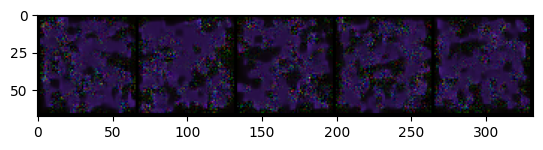

In [9]:
# 不使用DIP初始化
# 訓練DDPM模型，與前面相同，但不使用DIP初始化
for epoch in range(num_epochs):
    ddpm_model.train()
    total_loss = 0
    for x in tqdm(dataloader):
        x = x[0].cuda()
        t = torch.rand(x.size(0)).cuda()
        loss = diffusion_loss(ddpm_model, x, t)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(dataloader)}')

# 生成新圖片
generated_images = sample_ddpm(ddpm_model, 5)  # 生成5張新圖片

# 轉換為PIL圖片並顯示
generated_images = generated_images.cpu().clamp(0, 1)
grid = torchvision.utils.make_grid(generated_images, nrow=5)
np_grid = grid.numpy().transpose((1, 2, 0))

import matplotlib.pyplot as plt
plt.imshow(np_grid)
plt.show()


###**正式跑一次進行比較**

### 訓練DDPM模型（不使用DIP初始化）

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

# 定義簡單的DDPM模型
class SimpleDDPM(nn.Module):
    def __init__(self, image_size, in_channels, out_channels, hidden_dim):
        super(SimpleDDPM, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, hidden_dim, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(hidden_dim, hidden_dim, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(hidden_dim, out_channels, kernel_size=3, padding=1)

    def forward(self, x, t):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = self.conv3(x)
        return x

# 初始化模型和優化器
ddpm_model_no_dip = SimpleDDPM(image_size=64, in_channels=3, out_channels=3, hidden_dim=64).cuda()
optimizer = optim.Adam(ddpm_model_no_dip.parameters(), lr=0.001)
num_epochs = 100  # 訓練次數

# 定義擴散損失函數
def diffusion_loss(model, x, t):
    noise = torch.randn_like(x)
    x_noisy = x + noise * t.unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)
    predicted_noise = model(x_noisy, t)
    return nn.MSELoss()(predicted_noise, noise)

# 訓練模型（不使用DIP初始化）
losses_no_dip = []
for epoch in range(num_epochs):
    ddpm_model_no_dip.train()
    total_loss = 0
    for x in tqdm(dataloader):
        x = x[0].cuda()
        t = torch.rand(x.size(0)).cuda()
        loss = diffusion_loss(ddpm_model_no_dip, x, t)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(dataloader)
    losses_no_dip.append(avg_loss)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}')


100%|██████████| 223/223 [00:00<00:00, 443.75it/s]


Epoch 1/100, Loss: 0.2052


100%|██████████| 223/223 [00:00<00:00, 458.34it/s]


Epoch 2/100, Loss: 0.0950


100%|██████████| 223/223 [00:00<00:00, 450.19it/s]


Epoch 3/100, Loss: 0.0800


100%|██████████| 223/223 [00:00<00:00, 453.66it/s]


Epoch 4/100, Loss: 0.0695


100%|██████████| 223/223 [00:00<00:00, 450.82it/s]


Epoch 5/100, Loss: 0.0656


100%|██████████| 223/223 [00:00<00:00, 452.81it/s]


Epoch 6/100, Loss: 0.0623


100%|██████████| 223/223 [00:00<00:00, 455.34it/s]


Epoch 7/100, Loss: 0.0538


100%|██████████| 223/223 [00:00<00:00, 462.15it/s]


Epoch 8/100, Loss: 0.0623


100%|██████████| 223/223 [00:00<00:00, 451.64it/s]


Epoch 9/100, Loss: 0.0498


100%|██████████| 223/223 [00:00<00:00, 449.23it/s]


Epoch 10/100, Loss: 0.0507


100%|██████████| 223/223 [00:00<00:00, 444.90it/s]


Epoch 11/100, Loss: 0.0552


100%|██████████| 223/223 [00:00<00:00, 447.77it/s]


Epoch 12/100, Loss: 0.0622


100%|██████████| 223/223 [00:00<00:00, 454.74it/s]


Epoch 13/100, Loss: 0.0513


100%|██████████| 223/223 [00:00<00:00, 452.52it/s]


Epoch 14/100, Loss: 0.0495


100%|██████████| 223/223 [00:00<00:00, 454.10it/s]


Epoch 15/100, Loss: 0.0605


100%|██████████| 223/223 [00:00<00:00, 407.53it/s]


Epoch 16/100, Loss: 0.0441


100%|██████████| 223/223 [00:00<00:00, 421.52it/s]


Epoch 17/100, Loss: 0.0440


100%|██████████| 223/223 [00:00<00:00, 404.31it/s]


Epoch 18/100, Loss: 0.0495


100%|██████████| 223/223 [00:00<00:00, 418.62it/s]


Epoch 19/100, Loss: 0.0470


100%|██████████| 223/223 [00:00<00:00, 410.13it/s]


Epoch 20/100, Loss: 0.0492


100%|██████████| 223/223 [00:00<00:00, 387.35it/s]


Epoch 21/100, Loss: 0.0449


100%|██████████| 223/223 [00:00<00:00, 397.15it/s]


Epoch 22/100, Loss: 0.0405


100%|██████████| 223/223 [00:00<00:00, 445.84it/s]


Epoch 23/100, Loss: 0.0480


100%|██████████| 223/223 [00:00<00:00, 454.91it/s]


Epoch 24/100, Loss: 0.0529


100%|██████████| 223/223 [00:00<00:00, 452.18it/s]


Epoch 25/100, Loss: 0.0427


100%|██████████| 223/223 [00:00<00:00, 451.38it/s]


Epoch 26/100, Loss: 0.0455


100%|██████████| 223/223 [00:00<00:00, 453.89it/s]


Epoch 27/100, Loss: 0.0506


100%|██████████| 223/223 [00:00<00:00, 457.62it/s]


Epoch 28/100, Loss: 0.0415


100%|██████████| 223/223 [00:00<00:00, 454.18it/s]


Epoch 29/100, Loss: 0.0506


100%|██████████| 223/223 [00:00<00:00, 448.45it/s]


Epoch 30/100, Loss: 0.0474


100%|██████████| 223/223 [00:00<00:00, 449.51it/s]


Epoch 31/100, Loss: 0.0426


100%|██████████| 223/223 [00:00<00:00, 457.00it/s]


Epoch 32/100, Loss: 0.0439


100%|██████████| 223/223 [00:00<00:00, 451.94it/s]


Epoch 33/100, Loss: 0.0514


100%|██████████| 223/223 [00:00<00:00, 445.92it/s]


Epoch 34/100, Loss: 0.0392


100%|██████████| 223/223 [00:00<00:00, 442.46it/s]


Epoch 35/100, Loss: 0.0433


100%|██████████| 223/223 [00:00<00:00, 443.51it/s]


Epoch 36/100, Loss: 0.0419


100%|██████████| 223/223 [00:00<00:00, 454.79it/s]


Epoch 37/100, Loss: 0.0459


100%|██████████| 223/223 [00:00<00:00, 454.11it/s]


Epoch 38/100, Loss: 0.0419


100%|██████████| 223/223 [00:00<00:00, 459.53it/s]


Epoch 39/100, Loss: 0.0431


100%|██████████| 223/223 [00:00<00:00, 452.23it/s]


Epoch 40/100, Loss: 0.0486


100%|██████████| 223/223 [00:00<00:00, 451.14it/s]


Epoch 41/100, Loss: 0.0416


100%|██████████| 223/223 [00:00<00:00, 419.58it/s]


Epoch 42/100, Loss: 0.0431


100%|██████████| 223/223 [00:00<00:00, 413.91it/s]


Epoch 43/100, Loss: 0.0376


100%|██████████| 223/223 [00:00<00:00, 399.42it/s]


Epoch 44/100, Loss: 0.0429


100%|██████████| 223/223 [00:00<00:00, 407.62it/s]


Epoch 45/100, Loss: 0.0403


100%|██████████| 223/223 [00:00<00:00, 415.84it/s]


Epoch 46/100, Loss: 0.0419


100%|██████████| 223/223 [00:00<00:00, 387.05it/s]


Epoch 47/100, Loss: 0.0428


100%|██████████| 223/223 [00:00<00:00, 386.34it/s]


Epoch 48/100, Loss: 0.0461


100%|██████████| 223/223 [00:00<00:00, 433.19it/s]


Epoch 49/100, Loss: 0.0412


100%|██████████| 223/223 [00:00<00:00, 447.55it/s]


Epoch 50/100, Loss: 0.0358


100%|██████████| 223/223 [00:00<00:00, 454.59it/s]


Epoch 51/100, Loss: 0.0414


100%|██████████| 223/223 [00:00<00:00, 456.07it/s]


Epoch 52/100, Loss: 0.0451


100%|██████████| 223/223 [00:00<00:00, 452.71it/s]


Epoch 53/100, Loss: 0.0442


100%|██████████| 223/223 [00:00<00:00, 460.48it/s]


Epoch 54/100, Loss: 0.0355


100%|██████████| 223/223 [00:00<00:00, 449.83it/s]


Epoch 55/100, Loss: 0.0407


100%|██████████| 223/223 [00:00<00:00, 458.32it/s]


Epoch 56/100, Loss: 0.0393


100%|██████████| 223/223 [00:00<00:00, 456.31it/s]


Epoch 57/100, Loss: 0.0417


100%|██████████| 223/223 [00:00<00:00, 451.37it/s]


Epoch 58/100, Loss: 0.0412


100%|██████████| 223/223 [00:00<00:00, 457.98it/s]


Epoch 59/100, Loss: 0.0424


100%|██████████| 223/223 [00:00<00:00, 455.85it/s]


Epoch 60/100, Loss: 0.0413


100%|██████████| 223/223 [00:00<00:00, 460.61it/s]


Epoch 61/100, Loss: 0.0362


100%|██████████| 223/223 [00:00<00:00, 459.13it/s]


Epoch 62/100, Loss: 0.0441


100%|██████████| 223/223 [00:00<00:00, 458.92it/s]


Epoch 63/100, Loss: 0.0495


100%|██████████| 223/223 [00:00<00:00, 457.18it/s]


Epoch 64/100, Loss: 0.0571


100%|██████████| 223/223 [00:00<00:00, 462.90it/s]


Epoch 65/100, Loss: 0.0535


100%|██████████| 223/223 [00:00<00:00, 456.94it/s]


Epoch 66/100, Loss: 0.0402


100%|██████████| 223/223 [00:00<00:00, 453.71it/s]


Epoch 67/100, Loss: 0.0475


100%|██████████| 223/223 [00:00<00:00, 447.13it/s]


Epoch 68/100, Loss: 0.0394


100%|██████████| 223/223 [00:00<00:00, 410.48it/s]


Epoch 69/100, Loss: 0.0348


100%|██████████| 223/223 [00:00<00:00, 419.33it/s]


Epoch 70/100, Loss: 0.0417


100%|██████████| 223/223 [00:00<00:00, 388.31it/s]


Epoch 71/100, Loss: 0.0442


100%|██████████| 223/223 [00:00<00:00, 415.03it/s]


Epoch 72/100, Loss: 0.0439


100%|██████████| 223/223 [00:00<00:00, 403.50it/s]


Epoch 73/100, Loss: 0.0381


100%|██████████| 223/223 [00:00<00:00, 385.14it/s]


Epoch 74/100, Loss: 0.0380


100%|██████████| 223/223 [00:00<00:00, 396.83it/s]


Epoch 75/100, Loss: 0.0399


100%|██████████| 223/223 [00:00<00:00, 459.20it/s]


Epoch 76/100, Loss: 0.0398


100%|██████████| 223/223 [00:00<00:00, 450.26it/s]


Epoch 77/100, Loss: 0.0397


100%|██████████| 223/223 [00:00<00:00, 458.36it/s]


Epoch 78/100, Loss: 0.0387


100%|██████████| 223/223 [00:00<00:00, 455.39it/s]


Epoch 79/100, Loss: 0.0400


100%|██████████| 223/223 [00:00<00:00, 450.24it/s]


Epoch 80/100, Loss: 0.0397


100%|██████████| 223/223 [00:00<00:00, 450.30it/s]


Epoch 81/100, Loss: 0.0440


100%|██████████| 223/223 [00:00<00:00, 453.54it/s]


Epoch 82/100, Loss: 0.0420


100%|██████████| 223/223 [00:00<00:00, 456.88it/s]


Epoch 83/100, Loss: 0.0326


100%|██████████| 223/223 [00:00<00:00, 455.67it/s]


Epoch 84/100, Loss: 0.0369


100%|██████████| 223/223 [00:00<00:00, 452.35it/s]


Epoch 85/100, Loss: 0.0410


100%|██████████| 223/223 [00:00<00:00, 457.45it/s]


Epoch 86/100, Loss: 0.0336


100%|██████████| 223/223 [00:00<00:00, 456.95it/s]


Epoch 87/100, Loss: 0.0401


100%|██████████| 223/223 [00:00<00:00, 459.76it/s]


Epoch 88/100, Loss: 0.0427


100%|██████████| 223/223 [00:00<00:00, 461.88it/s]


Epoch 89/100, Loss: 0.0367


100%|██████████| 223/223 [00:00<00:00, 449.89it/s]


Epoch 90/100, Loss: 0.0353


100%|██████████| 223/223 [00:00<00:00, 455.85it/s]


Epoch 91/100, Loss: 0.0395


100%|██████████| 223/223 [00:00<00:00, 458.25it/s]


Epoch 92/100, Loss: 0.0363


100%|██████████| 223/223 [00:00<00:00, 458.84it/s]


Epoch 93/100, Loss: 0.0322


100%|██████████| 223/223 [00:00<00:00, 440.68it/s]


Epoch 94/100, Loss: 0.0368


100%|██████████| 223/223 [00:00<00:00, 425.32it/s]


Epoch 95/100, Loss: 0.0393


100%|██████████| 223/223 [00:00<00:00, 392.77it/s]


Epoch 96/100, Loss: 0.0329


100%|██████████| 223/223 [00:00<00:00, 397.33it/s]


Epoch 97/100, Loss: 0.0330


100%|██████████| 223/223 [00:00<00:00, 397.44it/s]


Epoch 98/100, Loss: 0.0327


100%|██████████| 223/223 [00:00<00:00, 409.76it/s]


Epoch 99/100, Loss: 0.0461


100%|██████████| 223/223 [00:00<00:00, 389.16it/s]

Epoch 100/100, Loss: 0.0351


### 訓練DDPM模型（使用DIP初始化）

In [11]:
# 定義DIP模型
class DIP(nn.Module):
    def __init__(self):
        super(DIP, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 3, kernel_size=3, padding=1)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = self.conv3(x)
        return x

# 訓練DIP模型
dip_model = DIP().cuda()
optimizer_dip = optim.Adam(dip_model.parameters(), lr=0.01)
criterion = nn.MSELoss()

def train_dip(model, target_image, num_epochs=1000):
    model.train()
    for epoch in range(num_epochs):
        optimizer_dip.zero_grad()
        output = model(target_image)
        loss = criterion(output, target_image)
        loss.backward()
        optimizer_dip.step()
        if (epoch + 1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
    return model

# 加載一張目標圖片進行DIP訓練
target_image = images[0].unsqueeze(0).cuda()
trained_dip_model = train_dip(dip_model, target_image)

# 使用DIP模型初始化DDPM
ddpm_model_with_dip = SimpleDDPM(image_size=64, in_channels=3, out_channels=3, hidden_dim=64).cuda()
with torch.no_grad():
    init_image = trained_dip_model(target_image).detach()

dataset_with_dip = torch.utils.data.TensorDataset(init_image.repeat(len(images), 1, 1, 1))
dataloader_with_dip = torch.utils.data.DataLoader(dataset_with_dip, batch_size=4, shuffle=True)

# 訓練DDPM模型（使用DIP初始化）
optimizer_ddpm_with_dip = optim.Adam(ddpm_model_with_dip.parameters(), lr=0.001)
losses_with_dip = []
for epoch in range(num_epochs):
    ddpm_model_with_dip.train()
    total_loss = 0
    for x in tqdm(dataloader_with_dip):
        x = x[0].cuda()
        t = torch.rand(x.size(0)).cuda()
        loss = diffusion_loss(ddpm_model_with_dip, x, t)
        optimizer_ddpm_with_dip.zero_grad()
        loss.backward()
        optimizer_ddpm_with_dip.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(dataloader_with_dip)
    losses_with_dip.append(avg_loss)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}')


Epoch [100/1000], Loss: 0.0019
Epoch [200/1000], Loss: 0.0014
Epoch [300/1000], Loss: 0.0013
Epoch [400/1000], Loss: 0.0011
Epoch [500/1000], Loss: 0.0009
Epoch [600/1000], Loss: 0.0008
Epoch [700/1000], Loss: 0.0008
Epoch [800/1000], Loss: 0.0008
Epoch [900/1000], Loss: 0.0008
Epoch [1000/1000], Loss: 0.0008


100%|██████████| 223/223 [00:00<00:00, 457.77it/s]


Epoch 1/100, Loss: 0.2129


100%|██████████| 223/223 [00:00<00:00, 448.23it/s]


Epoch 2/100, Loss: 0.1001


100%|██████████| 223/223 [00:00<00:00, 455.47it/s]


Epoch 3/100, Loss: 0.0903


100%|██████████| 223/223 [00:00<00:00, 452.29it/s]


Epoch 4/100, Loss: 0.0724


100%|██████████| 223/223 [00:00<00:00, 445.33it/s]


Epoch 5/100, Loss: 0.0679


100%|██████████| 223/223 [00:00<00:00, 450.23it/s]


Epoch 6/100, Loss: 0.0728


100%|██████████| 223/223 [00:00<00:00, 461.43it/s]


Epoch 7/100, Loss: 0.0678


100%|██████████| 223/223 [00:00<00:00, 457.23it/s]


Epoch 8/100, Loss: 0.0634


100%|██████████| 223/223 [00:00<00:00, 460.44it/s]


Epoch 9/100, Loss: 0.0700


100%|██████████| 223/223 [00:00<00:00, 450.62it/s]


Epoch 10/100, Loss: 0.0675


100%|██████████| 223/223 [00:00<00:00, 460.28it/s]


Epoch 11/100, Loss: 0.0567


100%|██████████| 223/223 [00:00<00:00, 461.03it/s]


Epoch 12/100, Loss: 0.0562


100%|██████████| 223/223 [00:00<00:00, 452.99it/s]


Epoch 13/100, Loss: 0.0560


100%|██████████| 223/223 [00:00<00:00, 455.16it/s]


Epoch 14/100, Loss: 0.0528


100%|██████████| 223/223 [00:00<00:00, 450.31it/s]


Epoch 15/100, Loss: 0.0527


100%|██████████| 223/223 [00:00<00:00, 455.31it/s]


Epoch 16/100, Loss: 0.0501


100%|██████████| 223/223 [00:00<00:00, 451.21it/s]


Epoch 17/100, Loss: 0.0675


100%|██████████| 223/223 [00:00<00:00, 417.11it/s]


Epoch 18/100, Loss: 0.0466


100%|██████████| 223/223 [00:00<00:00, 403.38it/s]


Epoch 19/100, Loss: 0.0514


100%|██████████| 223/223 [00:00<00:00, 400.23it/s]


Epoch 20/100, Loss: 0.0524


100%|██████████| 223/223 [00:00<00:00, 408.52it/s]


Epoch 21/100, Loss: 0.0515


100%|██████████| 223/223 [00:00<00:00, 414.10it/s]


Epoch 22/100, Loss: 0.0502


100%|██████████| 223/223 [00:00<00:00, 390.10it/s]


Epoch 23/100, Loss: 0.0716


100%|██████████| 223/223 [00:00<00:00, 389.13it/s]


Epoch 24/100, Loss: 0.0451


100%|██████████| 223/223 [00:00<00:00, 454.63it/s]


Epoch 25/100, Loss: 0.0492


100%|██████████| 223/223 [00:00<00:00, 449.22it/s]


Epoch 26/100, Loss: 0.0427


100%|██████████| 223/223 [00:00<00:00, 457.27it/s]


Epoch 27/100, Loss: 0.0439


100%|██████████| 223/223 [00:00<00:00, 443.67it/s]


Epoch 28/100, Loss: 0.0602


100%|██████████| 223/223 [00:00<00:00, 452.31it/s]


Epoch 29/100, Loss: 0.0463


100%|██████████| 223/223 [00:00<00:00, 456.38it/s]


Epoch 30/100, Loss: 0.0462


100%|██████████| 223/223 [00:00<00:00, 454.50it/s]


Epoch 31/100, Loss: 0.0540


100%|██████████| 223/223 [00:00<00:00, 454.76it/s]


Epoch 32/100, Loss: 0.0474


100%|██████████| 223/223 [00:00<00:00, 460.66it/s]


Epoch 33/100, Loss: 0.0441


100%|██████████| 223/223 [00:00<00:00, 443.48it/s]


Epoch 34/100, Loss: 0.0528


100%|██████████| 223/223 [00:00<00:00, 451.99it/s]


Epoch 35/100, Loss: 0.0437


100%|██████████| 223/223 [00:00<00:00, 444.05it/s]


Epoch 36/100, Loss: 0.0470


100%|██████████| 223/223 [00:00<00:00, 450.67it/s]


Epoch 37/100, Loss: 0.0458


100%|██████████| 223/223 [00:00<00:00, 451.53it/s]


Epoch 38/100, Loss: 0.0458


100%|██████████| 223/223 [00:00<00:00, 454.45it/s]


Epoch 39/100, Loss: 0.0472


100%|██████████| 223/223 [00:00<00:00, 453.41it/s]


Epoch 40/100, Loss: 0.0435


100%|██████████| 223/223 [00:00<00:00, 458.69it/s]


Epoch 41/100, Loss: 0.0486


100%|██████████| 223/223 [00:00<00:00, 459.25it/s]


Epoch 42/100, Loss: 0.0463


100%|██████████| 223/223 [00:00<00:00, 454.76it/s]


Epoch 43/100, Loss: 0.0461


100%|██████████| 223/223 [00:00<00:00, 449.55it/s]


Epoch 44/100, Loss: 0.0396


100%|██████████| 223/223 [00:00<00:00, 413.36it/s]


Epoch 45/100, Loss: 0.0534


100%|██████████| 223/223 [00:00<00:00, 420.34it/s]


Epoch 46/100, Loss: 0.0406


100%|██████████| 223/223 [00:00<00:00, 396.08it/s]


Epoch 47/100, Loss: 0.0499


100%|██████████| 223/223 [00:00<00:00, 410.61it/s]


Epoch 48/100, Loss: 0.0448


100%|██████████| 223/223 [00:00<00:00, 379.54it/s]


Epoch 49/100, Loss: 0.0467


100%|██████████| 223/223 [00:00<00:00, 381.07it/s]


Epoch 50/100, Loss: 0.0491


100%|██████████| 223/223 [00:00<00:00, 429.90it/s]


Epoch 51/100, Loss: 0.0511


100%|██████████| 223/223 [00:00<00:00, 454.43it/s]


Epoch 52/100, Loss: 0.0426


100%|██████████| 223/223 [00:00<00:00, 456.46it/s]


Epoch 53/100, Loss: 0.0392


100%|██████████| 223/223 [00:00<00:00, 444.19it/s]


Epoch 54/100, Loss: 0.0388


100%|██████████| 223/223 [00:00<00:00, 454.89it/s]


Epoch 55/100, Loss: 0.0500


100%|██████████| 223/223 [00:00<00:00, 459.56it/s]


Epoch 56/100, Loss: 0.0393


100%|██████████| 223/223 [00:00<00:00, 449.06it/s]


Epoch 57/100, Loss: 0.0532


100%|██████████| 223/223 [00:00<00:00, 456.16it/s]


Epoch 58/100, Loss: 0.0496


100%|██████████| 223/223 [00:00<00:00, 456.95it/s]


Epoch 59/100, Loss: 0.0367


100%|██████████| 223/223 [00:00<00:00, 457.24it/s]


Epoch 60/100, Loss: 0.0364


100%|██████████| 223/223 [00:00<00:00, 459.22it/s]


Epoch 61/100, Loss: 0.0427


100%|██████████| 223/223 [00:00<00:00, 456.41it/s]


Epoch 62/100, Loss: 0.0450


100%|██████████| 223/223 [00:00<00:00, 453.92it/s]


Epoch 63/100, Loss: 0.0429


100%|██████████| 223/223 [00:00<00:00, 447.90it/s]


Epoch 64/100, Loss: 0.0466


100%|██████████| 223/223 [00:00<00:00, 447.79it/s]


Epoch 65/100, Loss: 0.0387


100%|██████████| 223/223 [00:00<00:00, 457.00it/s]


Epoch 66/100, Loss: 0.0436


100%|██████████| 223/223 [00:00<00:00, 455.03it/s]


Epoch 67/100, Loss: 0.0444


100%|██████████| 223/223 [00:00<00:00, 464.30it/s]


Epoch 68/100, Loss: 0.0590


100%|██████████| 223/223 [00:00<00:00, 455.57it/s]


Epoch 69/100, Loss: 0.0445


100%|██████████| 223/223 [00:00<00:00, 454.09it/s]


Epoch 70/100, Loss: 0.0477


100%|██████████| 223/223 [00:00<00:00, 406.06it/s]


Epoch 71/100, Loss: 0.0479


100%|██████████| 223/223 [00:00<00:00, 419.14it/s]


Epoch 72/100, Loss: 0.0422


100%|██████████| 223/223 [00:00<00:00, 391.26it/s]


Epoch 73/100, Loss: 0.0401


100%|██████████| 223/223 [00:00<00:00, 416.88it/s]


Epoch 74/100, Loss: 0.0542


100%|██████████| 223/223 [00:00<00:00, 403.81it/s]


Epoch 75/100, Loss: 0.0443


100%|██████████| 223/223 [00:00<00:00, 379.98it/s]


Epoch 76/100, Loss: 0.0593


100%|██████████| 223/223 [00:00<00:00, 410.92it/s]


Epoch 77/100, Loss: 0.0389


100%|██████████| 223/223 [00:00<00:00, 446.05it/s]


Epoch 78/100, Loss: 0.0433


100%|██████████| 223/223 [00:00<00:00, 455.83it/s]


Epoch 79/100, Loss: 0.0397


100%|██████████| 223/223 [00:00<00:00, 445.08it/s]


Epoch 80/100, Loss: 0.0401


100%|██████████| 223/223 [00:00<00:00, 451.64it/s]


Epoch 81/100, Loss: 0.0461


100%|██████████| 223/223 [00:00<00:00, 451.90it/s]


Epoch 82/100, Loss: 0.0395


100%|██████████| 223/223 [00:00<00:00, 456.63it/s]


Epoch 83/100, Loss: 0.0361


100%|██████████| 223/223 [00:00<00:00, 449.04it/s]


Epoch 84/100, Loss: 0.0406


100%|██████████| 223/223 [00:00<00:00, 455.24it/s]


Epoch 85/100, Loss: 0.0464


100%|██████████| 223/223 [00:00<00:00, 443.92it/s]


Epoch 86/100, Loss: 0.0362


100%|██████████| 223/223 [00:00<00:00, 459.19it/s]


Epoch 87/100, Loss: 0.0390


100%|██████████| 223/223 [00:00<00:00, 454.52it/s]


Epoch 88/100, Loss: 0.0404


100%|██████████| 223/223 [00:00<00:00, 452.94it/s]


Epoch 89/100, Loss: 0.0493


100%|██████████| 223/223 [00:00<00:00, 449.33it/s]


Epoch 90/100, Loss: 0.0409


100%|██████████| 223/223 [00:00<00:00, 453.52it/s]


Epoch 91/100, Loss: 0.0405


100%|██████████| 223/223 [00:00<00:00, 459.16it/s]


Epoch 92/100, Loss: 0.0437


100%|██████████| 223/223 [00:00<00:00, 448.52it/s]


Epoch 93/100, Loss: 0.0378


100%|██████████| 223/223 [00:00<00:00, 456.52it/s]


Epoch 94/100, Loss: 0.0502


100%|██████████| 223/223 [00:00<00:00, 454.40it/s]


Epoch 95/100, Loss: 0.0430


100%|██████████| 223/223 [00:00<00:00, 457.64it/s]


Epoch 96/100, Loss: 0.0430


100%|██████████| 223/223 [00:00<00:00, 416.20it/s]


Epoch 97/100, Loss: 0.0418


100%|██████████| 223/223 [00:00<00:00, 403.81it/s]


Epoch 98/100, Loss: 0.0384


100%|██████████| 223/223 [00:00<00:00, 396.69it/s]


Epoch 99/100, Loss: 0.0363


100%|██████████| 223/223 [00:00<00:00, 395.32it/s]

Epoch 100/100, Loss: 0.0404


### 純粹使用DIP模型生成圖片


In [14]:
def generate_images_with_dip(model, num_images):
    model.eval()
    with torch.no_grad():
        generated_images = []
        for _ in range(num_images):
            noise_image = torch.randn(1, 3, 64, 64).cuda()  # 生成隨機噪聲圖片
            generated_image = model(noise_image).squeeze(0)
            generated_images.append(generated_image)
    return torch.stack(generated_images)

generated_images_with_pure_dip = generate_images_with_dip(trained_dip_model, 5)

### 生成新圖片並進行比較

<ipython-input-15-90719dcd5aca>:26: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_values.append(ssim(img1, img2, multichannel=True))


SSIM without DIP: 0.1541
SSIM with DIP: 0.2463
SSIM with pure DIP: 0.0192


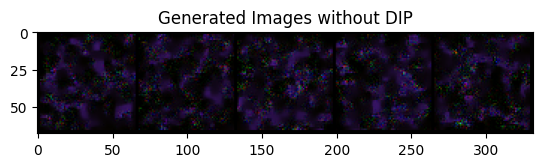

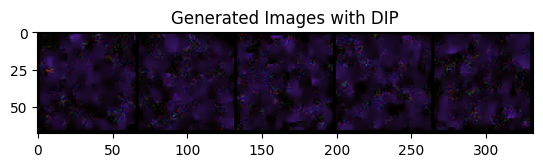

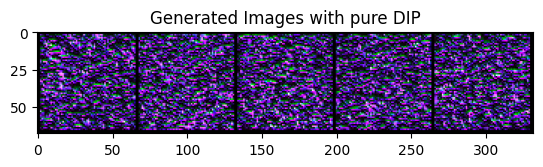

In [15]:
import torchvision
from skimage.metrics import structural_similarity as ssim

# 生成圖片函數
def sample_ddpm(model, num_samples, steps=1000):
    model.eval()
    with torch.no_grad():
        samples = torch.randn(num_samples, 3, 64, 64).cuda()
        for t in range(steps, 0, -1):
            predicted_noise = model(samples, torch.full((num_samples,), t/steps).cuda())
            samples = samples - predicted_noise / steps
    return samples

# 生成圖片（不使用DIP初始化）
generated_images_no_dip = sample_ddpm(ddpm_model_no_dip, 5)

# 生成圖片（使用DIP初始化）
generated_images_with_dip = sample_ddpm(ddpm_model_with_dip, 5)

# 定量評估生成圖片質量
def calculate_ssim(images1, images2):
    ssim_values = []
    for img1, img2 in zip(images1, images2):
        img1 = img1.permute(1, 2, 0).cpu().numpy()
        img2 = img2.permute(1, 2, 0).cpu().numpy()
        ssim_values.append(ssim(img1, img2, multichannel=True))
    return ssim_values

# 比較生成圖片質量
ssim_no_dip = calculate_ssim(generated_images_no_dip, images[:5])
ssim_with_dip = calculate_ssim(generated_images_with_dip, images[:5])
ssim_pure_dip = calculate_ssim(generated_images_with_pure_dip, images[:5])

print(f"SSIM without DIP: {sum(ssim_no_dip) / len(ssim_no_dip):.4f}")
print(f"SSIM with DIP: {sum(ssim_with_dip) / len(ssim_with_dip):.4f}")
print(f"SSIM with pure DIP: {sum(ssim_pure_dip) / len(ssim_pure_dip):.4f}")

# 顯示生成圖片
import matplotlib.pyplot as plt

def show_images(images, title):
    images = images.cpu().clamp(0, 1)
    grid = torchvision.utils.make_grid(images, nrow=5)
    np_grid = grid.numpy().transpose((1, 2, 0))
    plt.imshow(np_grid)
    plt.title(title)
    plt.show()

show_images(generated_images_no_dip, 'Generated Images without DIP')
show_images(generated_images_with_dip, 'Generated Images with DIP')
show_images(generated_images_with_pure_dip, 'Generated Images with pure DIP')


### PSNR

In [18]:
import torch
import torch.nn.functional as F

def calculate_psnr(img1, img2):
    mse = F.mse_loss(img1, img2)
    psnr = 20 * torch.log10(1.0 / torch.sqrt(mse))
    return psnr.item()

# 轉換圖片列表為Tensor對象
target_images_tensor = torch.stack(images[:5]).cuda()

# 計算生成圖片與目標圖片的PSNR
psnr_no_dip = calculate_psnr(generated_images_no_dip, target_images_tensor)
psnr_with_dip = calculate_psnr(generated_images_with_dip, target_images_tensor)
psnr_pure_dip = calculate_psnr(generated_images_with_pure_dip, target_images_tensor)

print(f"PSNR without DIP: {psnr_no_dip:.4f}")
print(f"PSNR with DIP: {psnr_with_dip:.4f}")
print(f"PSNR with pure DIP: {psnr_pure_dip:.4f}")

PSNR without DIP: 10.2402
PSNR with DIP: 11.0926
PSNR with pure DIP: 3.5081
